<a href="https://colab.research.google.com/github/vincent-grari/DIVERS/blob/main/FREQ_FAIR_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
print(sys.argv)
import os
import urllib
import os.path
import sklearn.preprocessing as preprocessing
from collections import namedtuple
import pandas as pd

['/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-2ae0bc4a-9799-4b27-a70d-c805f22b929a.json']


In [2]:
pip install --upgrade scikit-learn

In [3]:
!wget "http://grarivincent.com/research/baseINSEE.csv"

--2021-10-14 12:27:41--  http://grarivincent.com/research/baseINSEE.csv
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5107089 (4.9M) [text/csv]
Saving to: ‘baseINSEE.csv.1’

baseINSEE.csv.1     100%[===================>]   4.87M  2.07MB/s    in 2.4s    

2021-10-14 12:27:44 (2.07 MB/s) - ‘baseINSEE.csv.1’ saved [5107089/5107089]



In [4]:
baseINSEE = (pd.read_csv("baseINSEE.csv", #names=column_names,
                    sep=r'\s*;\s*', engine='python', na_values=['NA']))

In [5]:
baseINSEE['pol_insee_code']= baseINSEE['code_commune_INSEE']

In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))
def load_ICU_Pricing(path):
    #column_names = ["CalYear","Gender","Type","Category","Occupation","Age","Group1","Bonus","Poldur","Value","Adind","SubGroup2","Group2","Density","Y"]
    #input_data = (pd.read_csv(path, #names=column_names,
    #                           sep=r',', engine='python', keep_default_na=False, na_values=['NA']))
    
    path = "http://grarivincent.com/research/db4ModelFull2.csv"
    input_data = (pd.read_csv(path, #names=column_names,
                                sep=r',', engine='python', na_values=['NA']))
    input_data=input_data.drop(columns=['Unnamed: 0'])
    
    base=baseINSEE
    base = base[~base.pol_insee_code.str[:2].isin(["2A","2B"])]
    base["pol_insee_code"] = base["pol_insee_code"].astype(int)
    base_nd =  base.drop_duplicates(subset=['pol_insee_code'])

    input_data = input_data.drop_duplicates()
    input_data = input_data[~input_data.pol_insee_code.str[:2].isin(["2A","2B"])]
    input_data["pol_insee_code"] = input_data["pol_insee_code"].astype(int)

    input_data = input_data.merge(base_nd, how='inner', on="pol_insee_code")
    #input_data = input_data[input_data['claim_amount']<=5000]
    #input_data=input_data[input_data['claim_amount']!=0]
   
    #
    print(input_data.shape)
    G0 = (input_data.iloc[:, 37:180]) #137])
    #Z0 = pd.concat(Z0,input_data['long'])
    G0=G0.select_dtypes([np.number])
    G0 = G0.fillna(G0.mean())
    G0['Ratio_Femme']=G0['Nb Femme']/(G0['Nb Femme']+G0['Nb Homme'])
    S2 = G0['Ratio_Femme']

    G = (G0
          .drop(columns=['Nb Femme','Nb Homme','Ratio_Femme'])
          .fillna('Unknown').pipe(pd.get_dummies))
    #Z = (Z0
    #    .drop(columns=['"REG"'
    #                   ])
    #    .fillna('Unknown').pipe(pd.get_dummies))

    y = input_data['claim_nb']
    E  = input_data['exposure']
    #I = input_data["pol_insee_code"]
    I = input_data[['pol_insee_code','latitude','longitude']]

    # features; note that the 'target' and sentive attribute columns are dropped
    X0 = input_data.iloc[:, 5:32]
    
    X = (X0
          .drop(columns=['pol_coverage','pol_insee_code'])
          .fillna('Unknown').pipe(pd.get_dummies))
    
    S1 = X["drv_sex1_F"]
    X = X.drop(columns=['drv_sex1_F','drv_sex1_M','drv_sex2_F','drv_sex2_M'])

    INSEE = input_data.iloc[:, 36]
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives G: {G.shape[0]} samples, {G.shape[1]} attributes")
    print(f"sensitives E: {E.shape[0]} samples")
    print(f"sensitives I: {I.shape[0]} samples, {I.shape[1]} attributes")
    print(f"sensitives S1: {S1.shape[0]} samples")
    print(f"sensitives S2: {S1.shape[0]} samples")
    return X, y, G, E, I, S1, S2

X, y, G, E, I, S1, S2 =load_ICU_Pricing("http://grarivincent.com/research/db4modelfull3.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(98417, 151)
features X: 98417 samples, 1163 attributes
targets y: 98417 samples
sensitives G: 98417 samples, 88 attributes
sensitives E: 98417 samples
sensitives I: 98417 samples, 3 attributes
sensitives S1: 98417 samples
sensitives S2: 98417 samples


In [7]:
S2

0        0.510355
1        0.510355
2        0.524980
3        0.524980
4        0.524980
           ...   
98412    0.432432
98413    0.486339
98414    0.497382
98415    0.514806
98416    0.510604
Name: Ratio_Femme, Length: 98417, dtype: float64

In [8]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [9]:
(y>0).mean()

0.11202332930286434

In [10]:
G= G.iloc[:, :-5]

In [11]:
print(G.shape)

(98417, 83)


In [12]:
X_train, X_test, y_train, y_test, G_train, G_test, E_train, E_test, I_train, I_test, S1_train, S1_test, S2_train, S2_test  = train_test_split(X, y, G, E, I, S1, S2, test_size=0.2, random_state=7)

In [13]:
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [14]:
scalerg = StandardScaler().fit(G_train)
scale_df_g = lambda df, scaler: pd.DataFrame(scalerg.transform(df), columns=df.columns, index=df.index)
G_train = G_train.pipe(scale_df_g, scalerg) 
G_test = G_test.pipe(scale_df_g, scalerg)

In [15]:
y_traint =np.expand_dims(y_train,axis=1)
y_testt =np.expand_dims(y_test,axis=1)

In [16]:
X_train.head()

,pol_duration,pol_sit_duration,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_payd_No,pol_payd_Yes,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,drv_drv2_No,drv_drv2_Yes,drv_sex2_Unknown,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_make_ACL,vh_make_ALFA ROMEO,vh_make_ALPINE,vh_make_APAL,vh_make_ARO,vh_make_ASIA,vh_make_AUDI,vh_make_AUSTIN,vh_make_AUSTIN HEALEY,vh_make_AUTOBIANCHI,vh_make_AUVERLAND,vh_make_BABOULIN,vh_make_BEDFORD,vh_make_BENTLEY,vh_make_BERTONE,vh_make_BMW,vh_make_BREMACH,vh_make_BUICK,vh_make_CADILLAC,vh_make_CHEVROLET,vh_make_CHRYSLER,vh_make_CITROEN,vh_make_CORVETTE,vh_make_COURNIL,vh_make_DACIA,vh_make_DAEWOO,vh_make_DAF,vh_make_DAIHATSU,vh_make_DAIMLER,vh_make_DATSUN,vh_make_DODGE,vh_make_EBRO,vh_make_FERRARI,vh_make_FIAT,vh_make_FORD,vh_make_FSO,vh_make_GME,vh_make_HONDA,vh_make_HOTCHKISS,vh_make_HUMMER,vh_make_HYUNDAI,vh_make_INFINITI,vh_make_ISUZU,vh_make_IVECO,vh_make_JAGUAR,vh_make_JEEP,vh_make_KIA,vh_make_LADA VAZ,vh_make_LANCIA,vh_make_LAND ROVER,vh_make_LDV,vh_make_LEXUS,vh_make_LM SOVRA,vh_make_LOTUS,vh_make_MAHINDRA,vh_make_MASERATI,vh_make_MATRA,vh_make_MAZDA,vh_make_MEGA,vh_make_MERCEDES BENZ,vh_make_MG,vh_make_MINI,vh_make_MITSUBISHI,vh_make_MORGAN,vh_make_MORRIS,vh_make_NISSAN,vh_make_NSU,vh_make_OM,vh_make_OPEL,vh_make_PANHARD,vh_make_PEUGEOT,vh_make_PIAGGIO,vh_make_PININFARINA,vh_make_PONTIAC,vh_make_PORSCHE,vh_make_RENAULT,vh_make_RILEY,vh_make_ROVER,vh_make_SAAB,vh_make_SANTANA,vh_make_SAVIEM,vh_make_SEAT,vh_make_SIMCA,vh_make_SKODA,vh_make_SMART,vh_make_SSANGYONG,vh_make_STEYR PUCH,vh_make_SUBARU,vh_make_SUZUKI,vh_make_TALBOT,vh_make_TEILHOL,vh_make_TOYOTA,vh_make_TRIUMPH,vh_make_UMM,vh_make_UNIC,vh_make_UNIMOG,vh_make_VD 4 ROUES,vh_make_VOLKSWAGEN,vh_make_VOLVO,vh_make_VW PORSCHE,vh_make_WILLYS,vh_model_+4,vh_model_10,vh_model_100,vh_model_1000,vh_model_1007,vh_model_100NX,vh_model_104,vh_model_106,vh_model_107,vh_model_109,vh_model_110,vh_model_1100,vh_model_111,vh_model_114,vh_model_116,vh_model_116 I,vh_model_118,vh_model_118 I,vh_model_120,vh_model_120 I,vh_model_1200,vh_model_121,vh_model_123,vh_model_124,vh_model_125 I,vh_model_126,vh_model_1300,vh_model_1308,vh_model_135 I,vh_model_1500,vh_model_1502,vh_model_1602,vh_model_181,vh_model_190,vh_model_200,vh_model_2000,vh_model_200SX,vh_model_203,vh_model_204,vh_model_205,vh_model_206,vh_model_207,vh_model_208,vh_model_213,vh_model_214,vh_model_216,vh_model_218,vh_model_220,vh_model_230,vh_model_230 C,vh_model_230 G,vh_model_230 S,vh_model_24,vh_model_240,vh_model_25,vh_model_250,vh_model_260,vh_model_260Z,vh_model_280,vh_model_280 C,vh_model_280 S,vh_model_2CV,vh_model_2CV 4,vh_model_2CV 6,vh_model_300,vh_model_300 C,vh_model_300 G,vh_model_300 M,vh_model_300 S,vh_model_3000,vh_model_3008,vh_model_300ZX,vh_model_304,vh_model_305,vh_model_306,vh_model_307,vh_model_308,vh_model_309,vh_model_310,vh_model_315,vh_model_316,vh_model_316 I,vh_model_318,vh_model_318 I,vh_model_320,vh_model_320 I,vh_model_3200,vh_model_323,vh_model_323 I,vh_model_324,vh_model_325,vh_model_325 I,vh_model_328 I,vh_model_330,vh_model_330 I,vh_model_335,vh_model_340,vh_model_350 G,vh_model_350Z,vh_model_380 S,vh_model_4/4,vh_model_40,vh_model_400,vh_model_4007,vh_model_403,vh_model_404,vh_model_405,vh_model_406,vh_model_407,vh_model_408,vh_model_409,vh_model_410,vh_model_411,vh_model_414,vh_model_416,vh_model_418,vh_model_420,vh_model_440,vh_model_45,vh_model_450 S,vh_model_460,vh_model_480,vh_model_4CV,vh_model_4L,vh_model_500,vh_model_500 C,vh_model_500 S,vh_model_5008,vh_model_504,vh_model_505,vh_model_512,vh_model_518 I,vh_model_520,vh_model_520 I,vh_model_523 I,vh_model_524,vh_model_525,vh_model_525 I,vh_model_528 I,vh_model_530,vh_model_530 I,vh_model_535,vh_model_535 I,vh_model_545 I,vh_model_55,vh_model_560 S,vh_model_600,vh_model_600 S,vh_model_604,vh_model_605,vh_model_

### **GLM POISSON SANS ZONIER **

In [17]:
from sklearn import linear_model
reg = linear_model.PoissonRegressor() 
reg.fit(X_train,y_train)

PoissonRegressor()

In [18]:
def EDR_POIS(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  #loss=torch.mean(yhat-y*torch.log(yhat))
  eps=0.000000000001
  res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
  return res
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [19]:
class HGR_MIN_NN(nn.Module):
    
    def __init__(self,model_F,model_G,model_Y):
        super(HGR_MIN_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.mY = model_Y
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.0005)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.0005)
        self.optimizer_Y = torch.optim.Adam(self.mY.parameters(), lr=0.0001)

    def forward(self, x_var, y2, y_traint,x_vart,y_testt, y2t,nb,num_epochs,avt,lamb):
        criterionY = RMSELoss()
        seuil = num_epochs-avt
        ret= torch.FloatTensor([0.])
        for epoch in range(num_epochs):
            if (epoch % (num_epochs) == 0) & (epoch!=0):
                print('Epoch {}'.format(epoch+1))
                y_pred2= self.mY(x_var).data.numpy()
                accuracy = np.mean((y_traint- y_pred2)**2)
                #HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
        
                y_pred2t= self.mY(x_vart).data.numpy()
                accuracyt = np.mean((y_testt- y_pred2t)**2)
                print ("Train MSE:", round(accuracy,4),"lossY",lossY, "HGR Train NN",ret.data.numpy(),
                       #"HGR Train NN2:", HGR_NNP(model_pred(x_var),y2_var),
                       #"HGR Train KDE:", hgr(model_pred(x_var).squeeze(1),y2_var.squeeze(1),kde).data.numpy(),
                       "Test MSE:", round(accuracyt,4),"mean_Ypred", y_pred2.mean())#,"X2 Test :",ret,)
        
            #ret=0
            #### Predictor Classifier ####
            y_var = torch.FloatTensor(y_traint)
            y2_var = torch.FloatTensor(y2)
            yhat= self.mY(x_var)
            lossY =criterionY(yhat, y_var)
            epsilon=0.0000000000000000001
            #print(yhat)
            if epoch >= seuil:  #10000000000
                for j in range(nb) :
                    #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
                    #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))
        
                    yhat2  =yhat.data.numpy()
                    y2_var2=y2_var.data.numpy()
                
                    yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
                    y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)
        
                    pred_F  = self.mF(yhat2_PT)
                    pred_G  = self.mG(y2_var_PT)
        
                    #pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
                    #pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)
        
                    epsilon=0.000001
                    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                    #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                    #pred_G_norm[torch.isnan(pred_G_norm )] = 0
                    
                    ret = torch.mean(pred_F_norm*pred_G_norm)
                    loss = - ret  # maximize
                    self.mF.zero_grad()
                    self.mG.zero_grad()
                    loss.backward()
                    #print(loss)
                    self.optimizer_F.step()
                    self.optimizer_G.step()
            
            if epoch >= seuil:
                pred_F  = self.mF(yhat)
                pred_G  = self.mG(y2_var)
                #val_std = torch.std(pred_F) 
                #if torch.std(pred_F) < 0.0000000000000000001 :
                #    val_std = 0.0000000000000000001 
            
                epsilon=0.00000000001 
                pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                #pred_G_norm[torch.isnan(pred_G_norm )] = 0

                ret = torch.mean(pred_F_norm*pred_G_norm)  
            if epoch < seuil:
                ret= torch.FloatTensor([0.])
            loss =lossY + lamb*ret  #.data.numpy() 190
            #print(loss**2)
            self.optimizer_Y.zero_grad()
            loss.backward()
            #clip_value=0.000001
            #torch.nn.utils.clip_grad_norm_(model_pred.parameters(),clip_value)
            self.optimizer_Y.step()


In [20]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [21]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result


In [22]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-10-14 12:28:40--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py’

rdc.py              100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-10-14 12:28:41 (391 MB/s) - ‘rdc.py’ saved [2782/2782]



In [23]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [24]:

H = 15
H2 = 15


class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

In [25]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

In [26]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_train)))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_test)))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_train),y_train))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_test),y_test))
MSE_Poi_tr =  ((reg.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((reg.predict(X_test)-y_test)**2).mean()
print(" MSE Poi without zonier via Reg : ", MSE_Poi_tr)
print(" MSE Poi without zonier via Reg : ", MSE_Poi_test)

 GINI Poi without zonier via Reg :  0.08632237744697797
 GINI Poi without zonier via Reg :  0.08642011783024973
 EDR POIS Poi without zonier via Reg :  0.026036513749342016
 EDR POIS Poi without zonier via Reg :  0.02130601628235429
 MSE Poi without zonier via Reg :  0.13393763026042327
 MSE Poi without zonier via Reg :  0.13263529718681852


In [27]:
def FairQuant(y_pred, y, z_values, threshold=0.5):
    i=0.1
    vec=[]
    d = {'sensitivet': z_values, 'y_testt': y, 'y_pred3t': y_pred}
    df = pd.DataFrame(data=d)
    for i in np.arange(0.1,1.1,0.1):
        tableq = df[df.sensitivet <= df.quantile(i)['sensitivet']]
        residu_BIN  = tableq.y_pred3t.mean()
        residu_Glob = df.y_pred3t.mean()
        vec=np.append(vec,(residu_BIN-residu_Glob))
    FairQuantabs = np.mean(np.abs(vec))
    FairQuantsquare = np.mean(vec**2)
    return FairQuantabs,FairQuantsquare



In [28]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
y_pred2t= np.expand_dims(reg.predict(X_test),axis=1)

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
                          p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
                          DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ]])

 GINI Train :  0.08632237744697797
 GINI Test :  0.08642011783024973
 EDR Train :  0.026036513749232437
 EDR Test :  0.02130601628239015
 MSE Train :  0.13393763026042346
 MSE Test :  0.1326352971868185
 DispER train :  66.39943155940504
 DispER test :  9.686788708035792
 FairQuant train :  (0.0004976961204040287, 4.12835713775369e-07)
 FairQuant test :  (0.00043750846579141133, 3.1902276273192426e-07)
 RDC S1 train :  0.1005111507339258
 RDC S1 test :  0.10210645607971468
 RDC S2 train :  0.04470763200421496
 RDC S2 test :  0.06038370478293283
 HGR S1 train :  0.111639164
 HGR S1 test :  0.1054227
 HGR S2 train :  0.0
 HGR S2 test :  0.0


NameError: ignored

In [ ]:
reg.score(X_train,y_train)

0.026036513749242984

0.985191024892961


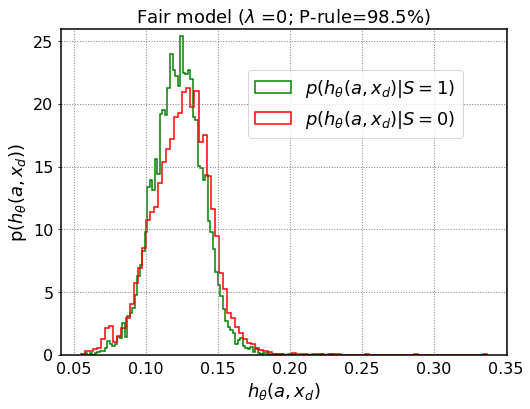

<Figure size 576x432 with 0 Axes>

In [72]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


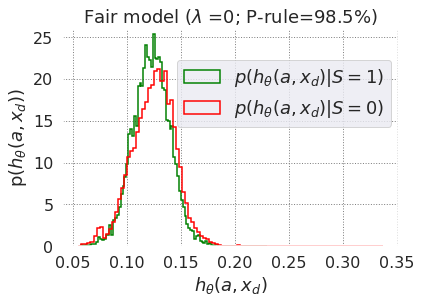

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


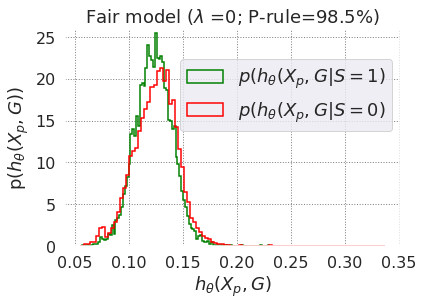

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


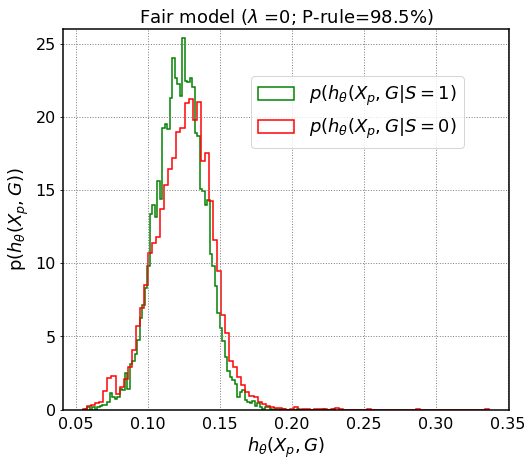

<Figure size 432x504 with 0 Axes>

In [65]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,7)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


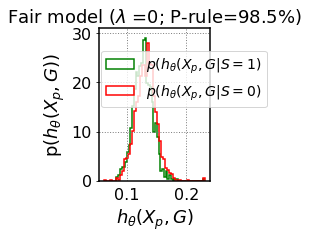

<Figure size 216x216 with 0 Axes>

In [60]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho & (y_testt.squeeze(1)>=1)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (y_testt.squeeze(1)>=1)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

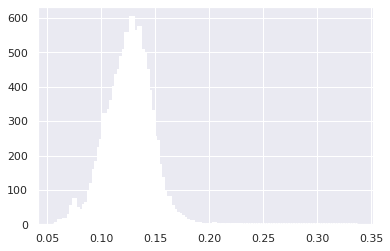

In [ ]:
_ = plt.hist(Ypredtest[Ho], bins='auto', lw=3, fc=(0, 0, 1, 0.5))
_ = plt.hist(Ypredtest[Fe], bins='auto', lw=3, fc=(1, 0, 0, 0.5))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


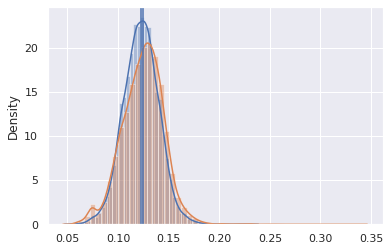

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.distplot(Ypredtest[Ho],norm_hist=1)
plt.axvline(x=Ypredtest[Ho].mean())
ax = sns.distplot(Ypredtest[Fe],norm_hist=1)
plt.axvline(x=Ypredtest[Fe].mean())

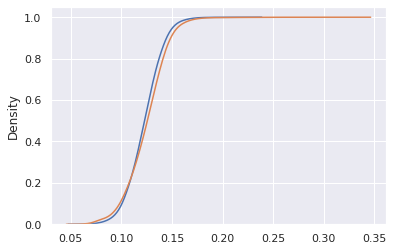

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)

ax = sns.kdeplot(Ypredtest[Ho].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe].squeeze(1),cumulative=True)


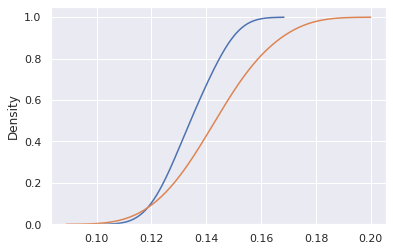

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=3).mean()

0.0006604348709611867

In [ ]:
(y_testt==0).shape

(19684, 1)

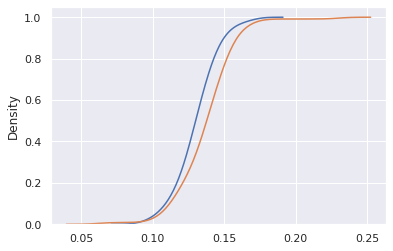

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=2).mean()

0.010770168664905507

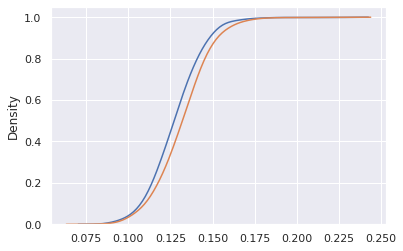

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)


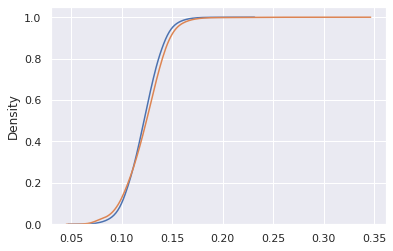

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)

In [ ]:

ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)Ho.shape

(19684,)

In [ ]:
Ypredtest[Ho & (ytest==1)]

NameError: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, sharex=False)
g = sns.distplot(quotient, hist=True, label=protname, ax=ax1, rug=True)
ax1.set_title('basic distplot (kde=True)')
# get distplot line points
line = g.get_lines()[0]
xd = line.get_xdata()
yd = line.get_ydata()
# https://stackoverflow.com/questions/29661574/normalize-numpy-array-columns-in-python
def normalize(x):
    return (x - x.min(0)) / x.ptp(0)
#normalize points
yd2 = normalize(yd)
# plot them in another graph
ax.plot(xd, yd2)
ax.set_title('basic distplot (kde=True)\nwith normalized y plot values')

plt.show()

0.12276542506161808

PRICING NN

In [ ]:
!wget "https://raw.githubusercontent.com/vincent-grari/DIVERS/main/pricing_nn.py"

--2021-10-04 09:03:18--  https://raw.githubusercontent.com/vincent-grari/DIVERS/main/pricing_nn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4771 (4.7K) [text/plain]
Saving to: ‘pricing_nn.py.1’

pricing_nn.py.1     100%[===================>]   4.66K  --.-KB/s    in 0s      

2021-10-04 09:03:18 (63.5 MB/s) - ‘pricing_nn.py.1’ saved [4771/4771]



In [ ]:
from pricing_nn import Pricing_NN

In [ ]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM(nn.Module):    
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

In [ ]:
P1_NN = Pricing_NN(regressor="poisson",mod_h=NN_GLM,mod_g= NN_G, batch_size = 128,nbepoch = 1024, lr = 0.0001, p_device= 'cuda')

In [ ]:
from tqdm import tqdm 
from sklearn.utils import shuffle
from torch.autograd import Variable

In [ ]:
P1_NN.fit(X_train, y_train, G_train, E_train)

KeyboardInterrupt: ignored

In [ ]:
P1_NN.predict(X_train, G_train, E_train)

tensor([[0.1014],
        [0.0891],
        [0.1915],
        ...,
        [0.0919],
        [0.0723],
        [0.1909]], device='cuda:0', grad_fn=<ExpBackward>)

In [ ]:
P1_NN.predict_g(G_train)

tensor([[13.3409],
        [16.1719],
        [11.9487],
        ...,
        [15.3951],
        [18.2578],
        [16.0916]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()


In [ ]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2t))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2,y_traint))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE NN without zonier via Reg : ", np.mean((y_traint- y_pred2)**2))
print(" MSE NN without zonier via Reg : ", np.mean((y_testt- y_pred2t)**2))

 GINI Poi without zonier via Reg :  0.3190141080347123
 GINI Poi without zonier via Reg :  0.32111758773443716
 EDR POIS Poi without zonier via Reg :  0.08233498570906495
 EDR POIS Poi without zonier via Reg :  -0.08617379652934676
 MSE NN without zonier via Reg :  0.12984692163346045
 MSE NN without zonier via Reg :  0.13423445220097072


FAIR PRICING NN

In [100]:
table = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [89]:
from tqdm import tqdm 
from sklearn.utils import shuffle
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from tqdm import tqdm 

class Fair_Pricing_NN(torch.nn.Module): 

    def __init__(self,regressor, mod_h,mod_g,lr,batch_size,p_device,nbepoch, lambdaHGR, nbepochHGR, start_epochHGR, mod_HGR_1,mod_HGR_2): 
        super().__init__()
        self.lr = lr
        self.batch_size = int(batch_size)
        self.device = torch.device(p_device)
        self.nbepoch = int(nbepoch)
        self.model_h = mod_h()
        self.model_g = mod_g()
        self.lambdaHGR = lambdaHGR
        self.nbepochHGR = int(nbepochHGR)
        self.start_epochHGR= int(start_epochHGR)
        self.mod_HGR_1 = mod_HGR_1()
        self.mod_HGR_2 = mod_HGR_2()
        if regressor == 'poisson': 
          # Use Adam to fit the model 
          self.criterion = self.Poisson_Loss
        elif regressor == 'gamma': 
          self.criterion = self.Gamma_Loss
        else: 
          print('Le regressor est mal renseigné: ("poisson" ou "gamma")')
    def forward(self, x): 
        out = self.linear(x) 
        return out 

    def predict(self, X_train,G_train,E_train): 
        e_var = torch.FloatTensor(np.expand_dims(E_train,axis = 1)).to(self.device)
        x_var = Variable(torch.FloatTensor(X_train.values)).to(self.device)
        g_out = self.predict_g(G_train)
        yhat= self.model_h(torch.cat((x_var,g_out),1),e_var)
        return yhat

    def predict_g(self, G_train): 
        g_var = Variable((torch.FloatTensor(G_train.values))).to(self.device)
        g_out = self.model_g(g_var)
        return g_out

    def Poisson_Loss(self,yhat, y):
      #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
      loss=torch.mean(yhat-y*torch.log(yhat))
      return loss
    
    def Gamma_Loss(self,yhat, y):
      #loss = torch.mean(yhat+(y-torch.log(yhat))/torch.log(yhat))
      loss = torch.mean(-torch.log(y/yhat)+(y-yhat)/yhat)
      return loss  
    
    def EDR_POIS(self, yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
      eps=0.000000000001
      res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
      return res
    
    def fit(self, X_train, y_train, G_train, E_train, S_train): 
        batch_no = len(X_train) // self.batch_size
        ##### PREDICTOR H #####
        #self.model_h=NN_POISS()
        #criterion = nn.PoissonNLLLoss()
 
        #criterion = self.Poisson_Loss
        #, eps=1e-8) #torch.nn.MSELoss() #reduction='mean'
        optimizer_h = torch.optim.Adam(self.model_h.parameters(), lr=self.lr)
        self.model_h.to(self.device)

        ##### PREDICTOR G #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_g = torch.optim.Adam(self.model_g.parameters(), lr=self.lr)
        self.model_g.to(self.device)

        ##### PREDICTOR HGR #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_HGR_1 = torch.optim.Adam(self.mod_HGR_1.parameters(), lr=self.lr)
        self.mod_HGR_1.to(self.device)
        optimizer_HGR_2 = torch.optim.Adam(self.mod_HGR_2.parameters(), lr=self.lr)
        self.mod_HGR_2.to(self.device)
        epsilon = 0.000000001
        for epoch in tqdm(range(1, self.nbepoch + 1), 'Epoch: ', leave=False):
            x_train, ytrain, g_train, e_train, s_train = shuffle(X_train.values,np.expand_dims(y_train,axis = 1),G_train.values,np.expand_dims(E_train,axis = 1),np.expand_dims(S_train,axis = 1))
            # Mini batch learning
            for i in range(batch_no):
                start = i * self.batch_size
                end = start + self.batch_size
                g_var = Variable(torch.FloatTensor(g_train[start:end])).to(self.device)
                e_var = Variable(torch.FloatTensor(e_train[start:end])).to(self.device)
                s_var = Variable(torch.FloatTensor(s_train[start:end])).to(self.device)
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(self.device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(self.device)
                # Forward + Backward + Optimize

                for l in range(1):
                  optimizer_g.zero_grad()
                  g_out = self.model_g(g_var)
                  ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                  #ypred_var=  model_h(x_var,e_var)
                  #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                  #loss = torch.mean(loss)
                  loss = self.criterion(ypred_var, y_var)
                  loss.backward()
                  optimizer_g.step()
                  #print('epoch :',epoch,'loss', loss)
                ypred_var0 = ypred_var.detach()
                if epoch >=self.start_epochHGR: 
                  for k in range(self.nbepochHGR) :
                    optimizer_HGR_1.zero_grad()
                    optimizer_HGR_2.zero_grad()

                    pred_F = self.mod_HGR_1(s_var.detach().to(self.device))
                    pred_G = self.mod_HGR_2(ypred_var0.to(self.device))
                    pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                    pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))

                    ret = torch.mean(pred_F_norm * pred_G_norm)
                    loss_HGR = - ret  # maximize
                    loss_HGR.backward()

                    optimizer_HGR_1.step()
                    optimizer_HGR_2.step()


                optimizer_h.zero_grad()
                g_out = self.model_g(g_var)
                ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                #ypred_var= model_h(x_var,e_var)
                #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                #loss = torch.mean(loss)
                pred_F = self.mod_HGR_1(s_var.detach().cuda())
                pred_G = self.mod_HGR_2(ypred_var)
                pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
                ret = torch.mean(pred_F_norm * pred_G_norm)
                loss = self.criterion(ypred_var, y_var) + self.lambdaHGR*ret
                loss.backward()
                optimizer_h.step()
                #print(epoch) 
                #print(ypred_var)
                if epoch >=self.start_epochHGR:   
                  print(ret)   
            print('EDR',loss. )
        yhat = self.predict(X_train, G_train, E_train).cpu().data.numpy()
        #print(yhat.shape)
        #print(y_train.shape)
        return print('DONE')

In [90]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM(nn.Module):    
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1


In [91]:
lamb_HGR =0.2
P1_NN = Fair_Pricing_NN(regressor="poisson",mod_h=NN_GLM,mod_g= NN_G, batch_size = 1024,nbepoch = 1024, lr = 0.0001, p_device= 'cuda', lambdaHGR=lamb_HGR, nbepochHGR=10, start_epochHGR=1025, mod_HGR_1=Net_HGR,mod_HGR_2= Net2_HGR)

In [92]:
P1_NN.fit(X_train, y_train, G_train, E_train, S1_train)

Epoch:   0%|          | 1/1024 [00:01<27:46,  1.63s/it]

EDR tensor(13300.8018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   0%|          | 2/1024 [00:03<33:39,  1.98s/it]

EDR tensor(1.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   0%|          | 3/1024 [00:05<31:05,  1.83s/it]

EDR tensor(3.7677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   0%|          | 4/1024 [00:07<29:53,  1.76s/it]

EDR tensor(1.8736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   0%|          | 5/1024 [00:08<29:06,  1.71s/it]

EDR tensor(2.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 6/1024 [00:10<28:37,  1.69s/it]

EDR tensor(1.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 7/1024 [00:12<28:17,  1.67s/it]

EDR tensor(1.1062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 8/1024 [00:13<28:03,  1.66s/it]

EDR tensor(1.1753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 9/1024 [00:15<27:46,  1.64s/it]

EDR tensor(1.3309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 10/1024 [00:16<27:48,  1.65s/it]

EDR tensor(1.0453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 11/1024 [00:18<27:33,  1.63s/it]

EDR tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|          | 12/1024 [00:20<27:26,  1.63s/it]

EDR tensor(1.1298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|▏         | 13/1024 [00:21<27:15,  1.62s/it]

EDR tensor(0.8828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|▏         | 14/1024 [00:23<27:16,  1.62s/it]

EDR tensor(0.8821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   1%|▏         | 15/1024 [00:24<27:05,  1.61s/it]

EDR tensor(1.1185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 16/1024 [00:26<27:12,  1.62s/it]

EDR tensor(0.8526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 17/1024 [00:28<27:17,  1.63s/it]

EDR tensor(2.8683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 18/1024 [00:29<27:17,  1.63s/it]

EDR tensor(0.7827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 19/1024 [00:31<27:12,  1.62s/it]

EDR tensor(0.7116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 20/1024 [00:33<27:10,  1.62s/it]

EDR tensor(0.7588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 21/1024 [00:34<27:02,  1.62s/it]

EDR tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 22/1024 [00:36<27:06,  1.62s/it]

EDR tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 23/1024 [00:37<26:56,  1.62s/it]

EDR tensor(0.6709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 24/1024 [00:39<27:02,  1.62s/it]

EDR tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   2%|▏         | 25/1024 [00:41<26:51,  1.61s/it]

EDR tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 26/1024 [00:42<26:49,  1.61s/it]

EDR tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 27/1024 [00:44<26:48,  1.61s/it]

EDR tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 28/1024 [00:46<26:45,  1.61s/it]

EDR tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 29/1024 [00:47<26:40,  1.61s/it]

EDR tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 30/1024 [00:49<26:45,  1.62s/it]

EDR tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 31/1024 [00:50<26:41,  1.61s/it]

EDR tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 32/1024 [00:52<26:45,  1.62s/it]

EDR tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 33/1024 [00:54<26:39,  1.61s/it]

EDR tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 34/1024 [00:55<26:44,  1.62s/it]

EDR tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   3%|▎         | 35/1024 [00:57<26:32,  1.61s/it]

EDR tensor(0.3872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▎         | 36/1024 [00:58<26:34,  1.61s/it]

EDR tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▎         | 37/1024 [01:00<26:53,  1.63s/it]

EDR tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▎         | 38/1024 [01:02<26:47,  1.63s/it]

EDR tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 39/1024 [01:03<26:38,  1.62s/it]

EDR tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 40/1024 [01:05<26:36,  1.62s/it]

EDR tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 41/1024 [01:07<26:36,  1.62s/it]

EDR tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 42/1024 [01:08<26:39,  1.63s/it]

EDR tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 43/1024 [01:10<26:33,  1.62s/it]

EDR tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 44/1024 [01:11<26:30,  1.62s/it]

EDR tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 45/1024 [01:13<26:18,  1.61s/it]

EDR tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   4%|▍         | 46/1024 [01:15<26:19,  1.62s/it]

EDR tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▍         | 47/1024 [01:16<26:17,  1.61s/it]

EDR tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▍         | 48/1024 [01:18<26:21,  1.62s/it]

EDR tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▍         | 49/1024 [01:20<26:18,  1.62s/it]

EDR tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▍         | 50/1024 [01:21<26:17,  1.62s/it]

EDR tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▍         | 51/1024 [01:23<26:14,  1.62s/it]

EDR tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▌         | 52/1024 [01:24<26:16,  1.62s/it]

EDR tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▌         | 53/1024 [01:26<26:12,  1.62s/it]

EDR tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▌         | 54/1024 [01:28<26:12,  1.62s/it]

EDR tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▌         | 55/1024 [01:29<26:09,  1.62s/it]

EDR tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   5%|▌         | 56/1024 [01:31<26:21,  1.63s/it]

EDR tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 57/1024 [01:33<26:14,  1.63s/it]

EDR tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 58/1024 [01:34<26:15,  1.63s/it]

EDR tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 59/1024 [01:36<26:05,  1.62s/it]

EDR tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 60/1024 [01:37<26:02,  1.62s/it]

EDR tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 61/1024 [01:39<25:58,  1.62s/it]

EDR tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 62/1024 [01:41<26:00,  1.62s/it]

EDR tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▌         | 63/1024 [01:42<25:55,  1.62s/it]

EDR tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▋         | 64/1024 [01:44<25:53,  1.62s/it]

EDR tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▋         | 65/1024 [01:45<25:47,  1.61s/it]

EDR tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   6%|▋         | 66/1024 [01:47<25:55,  1.62s/it]

EDR tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 67/1024 [01:49<25:48,  1.62s/it]

EDR tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 68/1024 [01:50<25:51,  1.62s/it]

EDR tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 69/1024 [01:52<25:47,  1.62s/it]

EDR tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 70/1024 [01:54<25:43,  1.62s/it]

EDR tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 71/1024 [01:55<25:41,  1.62s/it]

EDR tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 72/1024 [01:57<25:40,  1.62s/it]

EDR tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 73/1024 [01:58<25:34,  1.61s/it]

EDR tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 74/1024 [02:00<25:39,  1.62s/it]

EDR tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 75/1024 [02:02<25:34,  1.62s/it]

EDR tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   7%|▋         | 76/1024 [02:03<25:29,  1.61s/it]

EDR tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 77/1024 [02:05<25:20,  1.61s/it]

EDR tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 78/1024 [02:07<25:31,  1.62s/it]

EDR tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 79/1024 [02:08<25:29,  1.62s/it]

EDR tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 80/1024 [02:10<25:29,  1.62s/it]

EDR tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 81/1024 [02:11<25:22,  1.61s/it]

EDR tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 82/1024 [02:13<25:32,  1.63s/it]

EDR tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 83/1024 [02:15<25:26,  1.62s/it]

EDR tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 84/1024 [02:16<25:31,  1.63s/it]

EDR tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 85/1024 [02:18<25:26,  1.63s/it]

EDR tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 86/1024 [02:20<25:24,  1.63s/it]

EDR tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   8%|▊         | 87/1024 [02:21<25:12,  1.61s/it]

EDR tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▊         | 88/1024 [02:23<25:16,  1.62s/it]

EDR tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▊         | 89/1024 [02:24<25:09,  1.61s/it]

EDR tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 90/1024 [02:26<25:11,  1.62s/it]

EDR tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 91/1024 [02:28<25:04,  1.61s/it]

EDR tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 92/1024 [02:29<25:02,  1.61s/it]

EDR tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 93/1024 [02:31<24:56,  1.61s/it]

EDR tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 94/1024 [02:32<24:57,  1.61s/it]

EDR tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 95/1024 [02:34<24:56,  1.61s/it]

EDR tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 96/1024 [02:36<25:02,  1.62s/it]

EDR tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:   9%|▉         | 97/1024 [02:37<25:10,  1.63s/it]

EDR tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|▉         | 98/1024 [02:39<25:14,  1.64s/it]

EDR tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|▉         | 99/1024 [02:41<25:03,  1.63s/it]

EDR tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|▉         | 100/1024 [02:42<25:03,  1.63s/it]

EDR tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|▉         | 101/1024 [02:44<24:55,  1.62s/it]

EDR tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|▉         | 102/1024 [02:45<24:56,  1.62s/it]

EDR tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|█         | 103/1024 [02:47<25:01,  1.63s/it]

EDR tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|█         | 104/1024 [02:49<25:01,  1.63s/it]

EDR tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|█         | 105/1024 [02:50<24:54,  1.63s/it]

EDR tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|█         | 106/1024 [02:52<25:00,  1.63s/it]

EDR tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  10%|█         | 107/1024 [02:54<24:54,  1.63s/it]

EDR tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 108/1024 [02:55<24:55,  1.63s/it]

EDR tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 109/1024 [02:57<24:44,  1.62s/it]

EDR tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 110/1024 [02:58<24:42,  1.62s/it]

EDR tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 111/1024 [03:00<24:35,  1.62s/it]

EDR tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 112/1024 [03:02<24:34,  1.62s/it]

EDR tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 113/1024 [03:03<24:30,  1.61s/it]

EDR tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 114/1024 [03:05<24:32,  1.62s/it]

EDR tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█         | 115/1024 [03:07<24:30,  1.62s/it]

EDR tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█▏        | 116/1024 [03:08<24:37,  1.63s/it]

EDR tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  11%|█▏        | 117/1024 [03:10<24:25,  1.62s/it]

EDR tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 118/1024 [03:11<24:25,  1.62s/it]

EDR tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 119/1024 [03:13<24:32,  1.63s/it]

EDR tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 120/1024 [03:15<24:31,  1.63s/it]

EDR tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 121/1024 [03:16<24:31,  1.63s/it]

EDR tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 122/1024 [03:18<24:26,  1.63s/it]

EDR tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 123/1024 [03:20<24:20,  1.62s/it]

EDR tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 124/1024 [03:21<24:21,  1.62s/it]

EDR tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 125/1024 [03:23<24:14,  1.62s/it]

EDR tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 126/1024 [03:24<24:18,  1.62s/it]

EDR tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▏        | 127/1024 [03:26<24:17,  1.62s/it]

EDR tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  12%|█▎        | 128/1024 [03:28<24:18,  1.63s/it]

EDR tensor(0.3778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 129/1024 [03:29<24:13,  1.62s/it]

EDR tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 130/1024 [03:31<24:16,  1.63s/it]

EDR tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 131/1024 [03:33<24:10,  1.62s/it]

EDR tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 132/1024 [03:34<24:11,  1.63s/it]

EDR tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 133/1024 [03:36<24:01,  1.62s/it]

EDR tensor(0.3787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 134/1024 [03:37<24:07,  1.63s/it]

EDR tensor(0.3608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 135/1024 [03:39<24:02,  1.62s/it]

EDR tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 136/1024 [03:41<24:01,  1.62s/it]

EDR tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 137/1024 [03:42<23:54,  1.62s/it]

EDR tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  13%|█▎        | 138/1024 [03:44<23:55,  1.62s/it]

EDR tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▎        | 139/1024 [03:45<23:51,  1.62s/it]

EDR tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▎        | 140/1024 [03:47<23:50,  1.62s/it]

EDR tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 141/1024 [03:49<23:43,  1.61s/it]

EDR tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 142/1024 [03:50<23:45,  1.62s/it]

EDR tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 143/1024 [03:52<23:52,  1.63s/it]

EDR tensor(0.3379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 144/1024 [03:54<23:48,  1.62s/it]

EDR tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 145/1024 [03:55<23:40,  1.62s/it]

EDR tensor(0.3641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 146/1024 [03:57<23:43,  1.62s/it]

EDR tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 147/1024 [03:58<23:42,  1.62s/it]

EDR tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  14%|█▍        | 148/1024 [04:00<23:46,  1.63s/it]

EDR tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▍        | 149/1024 [04:02<23:36,  1.62s/it]

EDR tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▍        | 150/1024 [04:03<23:35,  1.62s/it]

EDR tensor(0.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▍        | 151/1024 [04:05<23:30,  1.62s/it]

EDR tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▍        | 152/1024 [04:07<23:33,  1.62s/it]

EDR tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▍        | 153/1024 [04:08<23:39,  1.63s/it]

EDR tensor(0.8242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▌        | 154/1024 [04:10<23:31,  1.62s/it]

EDR tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▌        | 155/1024 [04:11<23:29,  1.62s/it]

EDR tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▌        | 156/1024 [04:13<23:31,  1.63s/it]

EDR tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▌        | 157/1024 [04:15<23:27,  1.62s/it]

EDR tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  15%|█▌        | 158/1024 [04:16<23:27,  1.63s/it]

EDR tensor(0.3732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 159/1024 [04:18<23:23,  1.62s/it]

EDR tensor(0.3752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 160/1024 [04:20<23:11,  1.61s/it]

EDR tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 161/1024 [04:21<23:15,  1.62s/it]

EDR tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 162/1024 [04:23<23:04,  1.61s/it]

EDR tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 163/1024 [04:24<23:05,  1.61s/it]

EDR tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 164/1024 [04:26<22:59,  1.60s/it]

EDR tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 165/1024 [04:28<22:55,  1.60s/it]

EDR tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▌        | 166/1024 [04:29<22:54,  1.60s/it]

EDR tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▋        | 167/1024 [04:31<22:53,  1.60s/it]

EDR tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  16%|█▋        | 168/1024 [04:32<22:49,  1.60s/it]

EDR tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 169/1024 [04:34<22:50,  1.60s/it]

EDR tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 170/1024 [04:36<22:55,  1.61s/it]

EDR tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 171/1024 [04:37<22:53,  1.61s/it]

EDR tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 172/1024 [04:39<22:46,  1.60s/it]

EDR tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 173/1024 [04:40<22:45,  1.60s/it]

EDR tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 174/1024 [04:42<22:39,  1.60s/it]

EDR tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 175/1024 [04:44<22:35,  1.60s/it]

EDR tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 176/1024 [04:45<22:31,  1.59s/it]

EDR tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 177/1024 [04:47<22:28,  1.59s/it]

EDR tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 178/1024 [04:48<22:28,  1.59s/it]

EDR tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  17%|█▋        | 179/1024 [04:50<22:23,  1.59s/it]

EDR tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 180/1024 [04:52<22:27,  1.60s/it]

EDR tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 181/1024 [04:53<22:33,  1.61s/it]

EDR tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 182/1024 [04:55<22:33,  1.61s/it]

EDR tensor(0.3411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 183/1024 [04:56<22:35,  1.61s/it]

EDR tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 184/1024 [04:58<22:34,  1.61s/it]

EDR tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 185/1024 [05:00<22:28,  1.61s/it]

EDR tensor(0.2996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 186/1024 [05:01<22:26,  1.61s/it]

EDR tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 187/1024 [05:03<22:22,  1.60s/it]

EDR tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 188/1024 [05:04<22:15,  1.60s/it]

EDR tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  18%|█▊        | 189/1024 [05:06<22:26,  1.61s/it]

EDR tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▊        | 190/1024 [05:08<22:28,  1.62s/it]

EDR tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▊        | 191/1024 [05:09<22:24,  1.61s/it]

EDR tensor(0.3328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 192/1024 [05:11<22:13,  1.60s/it]

EDR tensor(0.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 193/1024 [05:12<22:09,  1.60s/it]

EDR tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 194/1024 [05:14<22:13,  1.61s/it]

EDR tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 195/1024 [05:16<22:10,  1.60s/it]

EDR tensor(0.3662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 196/1024 [05:17<22:03,  1.60s/it]

EDR tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 197/1024 [05:19<21:54,  1.59s/it]

EDR tensor(0.3464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 198/1024 [05:20<21:55,  1.59s/it]

EDR tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  19%|█▉        | 199/1024 [05:22<21:49,  1.59s/it]

EDR tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|█▉        | 200/1024 [05:24<21:47,  1.59s/it]

EDR tensor(0.2880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|█▉        | 201/1024 [05:25<21:59,  1.60s/it]

EDR tensor(0.3371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|█▉        | 202/1024 [05:27<21:56,  1.60s/it]

EDR tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|█▉        | 203/1024 [05:28<21:59,  1.61s/it]

EDR tensor(0.3037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|█▉        | 204/1024 [05:30<21:56,  1.61s/it]

EDR tensor(0.3412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|██        | 205/1024 [05:32<21:56,  1.61s/it]

EDR tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|██        | 206/1024 [05:33<21:58,  1.61s/it]

EDR tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|██        | 207/1024 [05:35<21:58,  1.61s/it]

EDR tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|██        | 208/1024 [05:37<22:05,  1.62s/it]

EDR tensor(0.3539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  20%|██        | 209/1024 [05:38<21:54,  1.61s/it]

EDR tensor(0.3015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 210/1024 [05:40<21:46,  1.60s/it]

EDR tensor(0.3124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 211/1024 [05:41<21:43,  1.60s/it]

EDR tensor(0.3258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 212/1024 [05:43<21:35,  1.60s/it]

EDR tensor(0.3167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 213/1024 [05:44<21:36,  1.60s/it]

EDR tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 214/1024 [05:46<21:26,  1.59s/it]

EDR tensor(0.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 215/1024 [05:48<21:29,  1.59s/it]

EDR tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 216/1024 [05:49<21:36,  1.60s/it]

EDR tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██        | 217/1024 [05:51<21:35,  1.61s/it]

EDR tensor(0.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██▏       | 218/1024 [05:52<21:28,  1.60s/it]

EDR tensor(0.3744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██▏       | 219/1024 [05:54<21:33,  1.61s/it]

EDR tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  21%|██▏       | 220/1024 [05:56<21:32,  1.61s/it]

EDR tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 221/1024 [05:57<21:36,  1.61s/it]

EDR tensor(0.3085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 222/1024 [05:59<21:30,  1.61s/it]

EDR tensor(0.3222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 223/1024 [06:00<21:20,  1.60s/it]

EDR tensor(0.3079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 224/1024 [06:02<21:22,  1.60s/it]

EDR tensor(0.3415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 225/1024 [06:04<21:19,  1.60s/it]

EDR tensor(0.3421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 226/1024 [06:05<21:18,  1.60s/it]

EDR tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 227/1024 [06:07<21:21,  1.61s/it]

EDR tensor(0.3570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 228/1024 [06:09<21:16,  1.60s/it]

EDR tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 229/1024 [06:10<21:17,  1.61s/it]

EDR tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  22%|██▏       | 230/1024 [06:12<21:10,  1.60s/it]

EDR tensor(0.3370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 231/1024 [06:13<21:08,  1.60s/it]

EDR tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 232/1024 [06:15<21:05,  1.60s/it]

EDR tensor(0.2982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 233/1024 [06:17<21:02,  1.60s/it]

EDR tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 234/1024 [06:18<20:58,  1.59s/it]

EDR tensor(0.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 235/1024 [06:20<20:55,  1.59s/it]

EDR tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 236/1024 [06:21<21:00,  1.60s/it]

EDR tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 237/1024 [06:23<20:56,  1.60s/it]

EDR tensor(0.3087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 238/1024 [06:24<20:53,  1.59s/it]

EDR tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 239/1024 [06:26<20:56,  1.60s/it]

EDR tensor(0.3848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  23%|██▎       | 240/1024 [06:28<20:53,  1.60s/it]

EDR tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▎       | 241/1024 [06:29<20:49,  1.60s/it]

EDR tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▎       | 242/1024 [06:31<20:48,  1.60s/it]

EDR tensor(0.3118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▎       | 243/1024 [06:33<20:53,  1.61s/it]

EDR tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 244/1024 [06:34<20:51,  1.60s/it]

EDR tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 245/1024 [06:36<20:48,  1.60s/it]

EDR tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 246/1024 [06:37<20:45,  1.60s/it]

EDR tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 247/1024 [06:39<20:43,  1.60s/it]

EDR tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 248/1024 [06:40<20:39,  1.60s/it]

EDR tensor(0.3602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 249/1024 [06:42<20:36,  1.60s/it]

EDR tensor(0.3106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  24%|██▍       | 250/1024 [06:44<20:33,  1.59s/it]

EDR tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▍       | 251/1024 [06:45<20:32,  1.59s/it]

EDR tensor(0.3449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▍       | 252/1024 [06:47<20:32,  1.60s/it]

EDR tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▍       | 253/1024 [06:48<20:34,  1.60s/it]

EDR tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▍       | 254/1024 [06:50<20:38,  1.61s/it]

EDR tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▍       | 255/1024 [06:52<20:35,  1.61s/it]

EDR tensor(0.3641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 256/1024 [06:53<20:39,  1.61s/it]

EDR tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 257/1024 [06:55<20:36,  1.61s/it]

EDR tensor(0.3297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 258/1024 [06:57<20:30,  1.61s/it]

EDR tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 259/1024 [06:58<20:29,  1.61s/it]

EDR tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 260/1024 [07:00<20:23,  1.60s/it]

EDR tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  25%|██▌       | 261/1024 [07:01<20:16,  1.59s/it]

EDR tensor(0.3058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 262/1024 [07:03<20:08,  1.59s/it]

EDR tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 263/1024 [07:05<20:23,  1.61s/it]

EDR tensor(0.3036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 264/1024 [07:06<20:24,  1.61s/it]

EDR tensor(0.2906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 265/1024 [07:08<20:22,  1.61s/it]

EDR tensor(0.3105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 266/1024 [07:09<20:16,  1.60s/it]

EDR tensor(0.3239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 267/1024 [07:11<20:18,  1.61s/it]

EDR tensor(0.3274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▌       | 268/1024 [07:13<20:10,  1.60s/it]

EDR tensor(0.3526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▋       | 269/1024 [07:14<20:06,  1.60s/it]

EDR tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▋       | 270/1024 [07:16<20:00,  1.59s/it]

EDR tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  26%|██▋       | 271/1024 [07:17<20:06,  1.60s/it]

EDR tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 272/1024 [07:19<20:01,  1.60s/it]

EDR tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 273/1024 [07:21<19:59,  1.60s/it]

EDR tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 274/1024 [07:22<19:59,  1.60s/it]

EDR tensor(0.3500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 275/1024 [07:24<19:57,  1.60s/it]

EDR tensor(0.3385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 276/1024 [07:25<19:54,  1.60s/it]

EDR tensor(0.3331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 277/1024 [07:27<19:51,  1.60s/it]

EDR tensor(0.2800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 278/1024 [07:29<19:47,  1.59s/it]

EDR tensor(0.3309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 279/1024 [07:30<19:44,  1.59s/it]

EDR tensor(0.2982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 280/1024 [07:32<19:40,  1.59s/it]

EDR tensor(0.3388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  27%|██▋       | 281/1024 [07:33<19:45,  1.60s/it]

EDR tensor(0.3374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 282/1024 [07:35<19:43,  1.60s/it]

EDR tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 283/1024 [07:37<19:47,  1.60s/it]

EDR tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 284/1024 [07:38<19:43,  1.60s/it]

EDR tensor(0.3274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 285/1024 [07:40<19:40,  1.60s/it]

EDR tensor(0.3209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 286/1024 [07:41<19:36,  1.59s/it]

EDR tensor(0.2994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 287/1024 [07:43<19:34,  1.59s/it]

EDR tensor(0.3239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 288/1024 [07:44<19:33,  1.59s/it]

EDR tensor(0.3234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 289/1024 [07:46<19:30,  1.59s/it]

EDR tensor(0.2938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 290/1024 [07:48<19:26,  1.59s/it]

EDR tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  28%|██▊       | 291/1024 [07:49<19:26,  1.59s/it]

EDR tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▊       | 292/1024 [07:51<19:21,  1.59s/it]

EDR tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▊       | 293/1024 [07:52<19:24,  1.59s/it]

EDR tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▊       | 294/1024 [07:54<19:25,  1.60s/it]

EDR tensor(0.3113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 295/1024 [07:56<19:22,  1.59s/it]

EDR tensor(0.3350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 296/1024 [07:57<19:20,  1.59s/it]

EDR tensor(0.3124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 297/1024 [07:59<19:17,  1.59s/it]

EDR tensor(0.3274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 298/1024 [08:00<19:15,  1.59s/it]

EDR tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 299/1024 [08:02<19:15,  1.59s/it]

EDR tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 300/1024 [08:04<19:10,  1.59s/it]

EDR tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 301/1024 [08:05<19:14,  1.60s/it]

EDR tensor(0.3049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  29%|██▉       | 302/1024 [08:07<19:11,  1.60s/it]

EDR tensor(0.3488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|██▉       | 303/1024 [08:08<19:12,  1.60s/it]

EDR tensor(0.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|██▉       | 304/1024 [08:10<19:16,  1.61s/it]

EDR tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|██▉       | 305/1024 [08:12<19:13,  1.60s/it]

EDR tensor(0.3050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|██▉       | 306/1024 [08:13<19:20,  1.62s/it]

EDR tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|██▉       | 307/1024 [08:15<19:18,  1.62s/it]

EDR tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|███       | 308/1024 [08:16<19:16,  1.62s/it]

EDR tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|███       | 309/1024 [08:18<19:15,  1.62s/it]

EDR tensor(0.3339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|███       | 310/1024 [08:20<19:06,  1.61s/it]

EDR tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|███       | 311/1024 [08:21<19:04,  1.61s/it]

EDR tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  30%|███       | 312/1024 [08:23<19:03,  1.61s/it]

EDR tensor(0.2846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 313/1024 [08:24<18:58,  1.60s/it]

EDR tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 314/1024 [08:26<18:57,  1.60s/it]

EDR tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 315/1024 [08:28<18:52,  1.60s/it]

EDR tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 316/1024 [08:29<18:52,  1.60s/it]

EDR tensor(0.3569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 317/1024 [08:31<18:47,  1.59s/it]

EDR tensor(0.3353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 318/1024 [08:32<18:42,  1.59s/it]

EDR tensor(0.3199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███       | 319/1024 [08:34<18:43,  1.59s/it]

EDR tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███▏      | 320/1024 [08:36<18:41,  1.59s/it]

EDR tensor(0.3304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███▏      | 321/1024 [08:37<18:44,  1.60s/it]

EDR tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  31%|███▏      | 322/1024 [08:39<18:39,  1.59s/it]

EDR tensor(0.3156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 323/1024 [08:40<18:37,  1.59s/it]

EDR tensor(0.2866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 324/1024 [08:42<18:36,  1.59s/it]

EDR tensor(0.3224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 325/1024 [08:44<18:34,  1.59s/it]

EDR tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 326/1024 [08:45<18:31,  1.59s/it]

EDR tensor(0.3139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 327/1024 [08:47<18:30,  1.59s/it]

EDR tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 328/1024 [08:48<18:29,  1.59s/it]

EDR tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 329/1024 [08:50<18:30,  1.60s/it]

EDR tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 330/1024 [08:52<18:25,  1.59s/it]

EDR tensor(0.2938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 331/1024 [08:53<18:28,  1.60s/it]

EDR tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  32%|███▏      | 332/1024 [08:55<18:29,  1.60s/it]

EDR tensor(0.2729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 333/1024 [08:56<18:27,  1.60s/it]

EDR tensor(0.3118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 334/1024 [08:58<18:31,  1.61s/it]

EDR tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 335/1024 [09:00<18:26,  1.61s/it]

EDR tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 336/1024 [09:01<18:21,  1.60s/it]

EDR tensor(0.3268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 337/1024 [09:03<18:20,  1.60s/it]

EDR tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 338/1024 [09:04<18:22,  1.61s/it]

EDR tensor(0.3323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 339/1024 [09:06<18:23,  1.61s/it]

EDR tensor(0.3403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 340/1024 [09:08<18:20,  1.61s/it]

EDR tensor(0.2824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 341/1024 [09:09<18:15,  1.60s/it]

EDR tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 342/1024 [09:11<18:11,  1.60s/it]

EDR tensor(0.3026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  33%|███▎      | 343/1024 [09:12<18:05,  1.59s/it]

EDR tensor(0.3028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▎      | 344/1024 [09:14<18:04,  1.59s/it]

EDR tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▎      | 345/1024 [09:16<18:03,  1.60s/it]

EDR tensor(0.3195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 346/1024 [09:17<18:02,  1.60s/it]

EDR tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 347/1024 [09:19<18:02,  1.60s/it]

EDR tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 348/1024 [09:20<17:57,  1.59s/it]

EDR tensor(0.3082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 349/1024 [09:22<17:58,  1.60s/it]

EDR tensor(0.3164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 350/1024 [09:24<17:52,  1.59s/it]

EDR tensor(0.3241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 351/1024 [09:25<17:52,  1.59s/it]

EDR tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 352/1024 [09:27<17:49,  1.59s/it]

EDR tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  34%|███▍      | 353/1024 [09:28<17:57,  1.61s/it]

EDR tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▍      | 354/1024 [09:30<17:55,  1.61s/it]

EDR tensor(0.3278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▍      | 355/1024 [09:32<17:56,  1.61s/it]

EDR tensor(0.3037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▍      | 356/1024 [09:33<17:57,  1.61s/it]

EDR tensor(0.3509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▍      | 357/1024 [09:35<17:53,  1.61s/it]

EDR tensor(0.3581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▍      | 358/1024 [09:36<17:51,  1.61s/it]

EDR tensor(0.2975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▌      | 359/1024 [09:38<17:51,  1.61s/it]

EDR tensor(0.3288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▌      | 360/1024 [09:40<17:44,  1.60s/it]

EDR tensor(0.3492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▌      | 361/1024 [09:41<17:43,  1.60s/it]

EDR tensor(0.2927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▌      | 362/1024 [09:43<17:41,  1.60s/it]

EDR tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  35%|███▌      | 363/1024 [09:44<17:41,  1.61s/it]

EDR tensor(0.3306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 364/1024 [09:46<17:34,  1.60s/it]

EDR tensor(0.3071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 365/1024 [09:48<17:33,  1.60s/it]

EDR tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 366/1024 [09:49<17:31,  1.60s/it]

EDR tensor(0.3303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 367/1024 [09:51<17:30,  1.60s/it]

EDR tensor(0.2820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 368/1024 [09:52<17:24,  1.59s/it]

EDR tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 369/1024 [09:54<17:26,  1.60s/it]

EDR tensor(0.3221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 370/1024 [09:56<17:23,  1.60s/it]

EDR tensor(0.3752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▌      | 371/1024 [09:57<17:24,  1.60s/it]

EDR tensor(0.2987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▋      | 372/1024 [09:59<17:22,  1.60s/it]

EDR tensor(0.3448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  36%|███▋      | 373/1024 [10:00<17:25,  1.61s/it]

EDR tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 374/1024 [10:02<17:23,  1.61s/it]

EDR tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 375/1024 [10:04<17:21,  1.60s/it]

EDR tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 376/1024 [10:05<17:15,  1.60s/it]

EDR tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 377/1024 [10:07<17:19,  1.61s/it]

EDR tensor(0.3312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 378/1024 [10:08<17:14,  1.60s/it]

EDR tensor(0.3065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 379/1024 [10:10<17:13,  1.60s/it]

EDR tensor(0.3205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 380/1024 [10:12<17:07,  1.60s/it]

EDR tensor(0.3416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 381/1024 [10:13<17:08,  1.60s/it]

EDR tensor(0.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 382/1024 [10:15<17:04,  1.60s/it]

EDR tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  37%|███▋      | 383/1024 [10:16<17:03,  1.60s/it]

EDR tensor(0.3100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 384/1024 [10:18<16:59,  1.59s/it]

EDR tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 385/1024 [10:20<16:59,  1.60s/it]

EDR tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 386/1024 [10:21<17:01,  1.60s/it]

EDR tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 387/1024 [10:23<17:05,  1.61s/it]

EDR tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 388/1024 [10:24<17:01,  1.61s/it]

EDR tensor(0.2771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 389/1024 [10:26<17:00,  1.61s/it]

EDR tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 390/1024 [10:28<16:51,  1.60s/it]

EDR tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 391/1024 [10:29<16:56,  1.61s/it]

EDR tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 392/1024 [10:31<16:50,  1.60s/it]

EDR tensor(0.3526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 393/1024 [10:32<16:47,  1.60s/it]

EDR tensor(0.3195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  38%|███▊      | 394/1024 [10:34<16:46,  1.60s/it]

EDR tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▊      | 395/1024 [10:36<16:44,  1.60s/it]

EDR tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▊      | 396/1024 [10:37<16:43,  1.60s/it]

EDR tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 397/1024 [10:39<16:40,  1.60s/it]

EDR tensor(0.2748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 398/1024 [10:40<16:37,  1.59s/it]

EDR tensor(0.3230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 399/1024 [10:42<16:36,  1.60s/it]

EDR tensor(0.3302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 400/1024 [10:44<16:34,  1.59s/it]

EDR tensor(0.3072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 401/1024 [10:45<16:33,  1.59s/it]

EDR tensor(0.3350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 402/1024 [10:47<16:32,  1.60s/it]

EDR tensor(0.3224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 403/1024 [10:48<16:26,  1.59s/it]

EDR tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  39%|███▉      | 404/1024 [10:50<16:25,  1.59s/it]

EDR tensor(0.3138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|███▉      | 405/1024 [10:52<16:27,  1.59s/it]

EDR tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|███▉      | 406/1024 [10:53<16:30,  1.60s/it]

EDR tensor(0.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|███▉      | 407/1024 [10:55<16:27,  1.60s/it]

EDR tensor(0.3041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|███▉      | 408/1024 [10:56<16:33,  1.61s/it]

EDR tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|███▉      | 409/1024 [10:58<16:31,  1.61s/it]

EDR tensor(0.3420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|████      | 410/1024 [11:00<16:26,  1.61s/it]

EDR tensor(0.3006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|████      | 411/1024 [11:01<16:25,  1.61s/it]

EDR tensor(0.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|████      | 412/1024 [11:03<16:22,  1.60s/it]

EDR tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|████      | 413/1024 [11:04<16:19,  1.60s/it]

EDR tensor(0.3445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  40%|████      | 414/1024 [11:06<16:17,  1.60s/it]

EDR tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 415/1024 [11:08<16:16,  1.60s/it]

EDR tensor(0.3187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 416/1024 [11:09<16:15,  1.60s/it]

EDR tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 417/1024 [11:11<16:12,  1.60s/it]

EDR tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 418/1024 [11:12<16:08,  1.60s/it]

EDR tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 419/1024 [11:14<16:11,  1.61s/it]

EDR tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 420/1024 [11:16<16:03,  1.59s/it]

EDR tensor(0.3287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 421/1024 [11:17<16:02,  1.60s/it]

EDR tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████      | 422/1024 [11:19<15:58,  1.59s/it]

EDR tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████▏     | 423/1024 [11:20<15:58,  1.60s/it]

EDR tensor(0.3477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  41%|████▏     | 424/1024 [11:22<15:54,  1.59s/it]

EDR tensor(0.2903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 425/1024 [11:24<15:51,  1.59s/it]

EDR tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 426/1024 [11:25<15:50,  1.59s/it]

EDR tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 427/1024 [11:27<15:49,  1.59s/it]

EDR tensor(0.3029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 428/1024 [11:28<15:47,  1.59s/it]

EDR tensor(0.3267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 429/1024 [11:30<15:50,  1.60s/it]

EDR tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 430/1024 [11:32<15:46,  1.59s/it]

EDR tensor(0.2893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 431/1024 [11:33<15:49,  1.60s/it]

EDR tensor(0.3090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 432/1024 [11:35<15:45,  1.60s/it]

EDR tensor(0.3340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 433/1024 [11:36<15:46,  1.60s/it]

EDR tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 434/1024 [11:38<15:44,  1.60s/it]

EDR tensor(0.3067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  42%|████▏     | 435/1024 [11:40<15:43,  1.60s/it]

EDR tensor(0.2623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 436/1024 [11:41<15:41,  1.60s/it]

EDR tensor(0.3568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 437/1024 [11:43<15:36,  1.60s/it]

EDR tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 438/1024 [11:44<15:36,  1.60s/it]

EDR tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 439/1024 [11:46<15:33,  1.60s/it]

EDR tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 440/1024 [11:48<15:29,  1.59s/it]

EDR tensor(0.2929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 441/1024 [11:49<15:34,  1.60s/it]

EDR tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 442/1024 [11:51<15:31,  1.60s/it]

EDR tensor(0.3104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 443/1024 [11:52<15:29,  1.60s/it]

EDR tensor(0.2757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 444/1024 [11:54<15:25,  1.60s/it]

EDR tensor(0.2872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  43%|████▎     | 445/1024 [11:56<15:27,  1.60s/it]

EDR tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▎     | 446/1024 [11:57<15:23,  1.60s/it]

EDR tensor(0.3069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▎     | 447/1024 [11:59<15:21,  1.60s/it]

EDR tensor(0.2744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 448/1024 [12:00<15:20,  1.60s/it]

EDR tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 449/1024 [12:02<15:24,  1.61s/it]

EDR tensor(0.3236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 450/1024 [12:04<15:19,  1.60s/it]

EDR tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 451/1024 [12:05<15:19,  1.60s/it]

EDR tensor(0.3005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 452/1024 [12:07<15:16,  1.60s/it]

EDR tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 453/1024 [12:08<15:16,  1.60s/it]

EDR tensor(0.3869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 454/1024 [12:10<15:17,  1.61s/it]

EDR tensor(0.3087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  44%|████▍     | 455/1024 [12:12<15:15,  1.61s/it]

EDR tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▍     | 456/1024 [12:13<15:11,  1.60s/it]

EDR tensor(0.3340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▍     | 457/1024 [12:15<15:09,  1.60s/it]

EDR tensor(0.3175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▍     | 458/1024 [12:16<15:06,  1.60s/it]

EDR tensor(0.2580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▍     | 459/1024 [12:18<15:04,  1.60s/it]

EDR tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▍     | 460/1024 [12:20<15:00,  1.60s/it]

EDR tensor(0.3167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▌     | 461/1024 [12:21<15:01,  1.60s/it]

EDR tensor(0.3204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▌     | 462/1024 [12:23<14:55,  1.59s/it]

EDR tensor(0.3073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▌     | 463/1024 [12:24<14:55,  1.60s/it]

EDR tensor(0.3123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▌     | 464/1024 [12:26<14:55,  1.60s/it]

EDR tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  45%|████▌     | 465/1024 [12:28<14:51,  1.59s/it]

EDR tensor(0.3228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 466/1024 [12:29<14:49,  1.59s/it]

EDR tensor(0.3209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 467/1024 [12:31<14:47,  1.59s/it]

EDR tensor(0.2761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 468/1024 [12:32<14:46,  1.59s/it]

EDR tensor(0.2736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 469/1024 [12:34<14:46,  1.60s/it]

EDR tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 470/1024 [12:36<14:45,  1.60s/it]

EDR tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 471/1024 [12:37<14:48,  1.61s/it]

EDR tensor(0.3216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 472/1024 [12:39<14:42,  1.60s/it]

EDR tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▌     | 473/1024 [12:40<14:40,  1.60s/it]

EDR tensor(0.3223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▋     | 474/1024 [12:42<14:35,  1.59s/it]

EDR tensor(0.3186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▋     | 475/1024 [12:44<14:34,  1.59s/it]

EDR tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  46%|████▋     | 476/1024 [12:45<14:34,  1.60s/it]

EDR tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 477/1024 [12:47<14:34,  1.60s/it]

EDR tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 478/1024 [12:48<14:31,  1.60s/it]

EDR tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 479/1024 [12:50<14:26,  1.59s/it]

EDR tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 480/1024 [12:52<14:24,  1.59s/it]

EDR tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 481/1024 [12:53<14:25,  1.59s/it]

EDR tensor(0.3078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 482/1024 [12:55<14:22,  1.59s/it]

EDR tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 483/1024 [12:56<14:20,  1.59s/it]

EDR tensor(0.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 484/1024 [12:58<14:18,  1.59s/it]

EDR tensor(0.3073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 485/1024 [12:59<14:18,  1.59s/it]

EDR tensor(0.3467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  47%|████▋     | 486/1024 [13:01<14:16,  1.59s/it]

EDR tensor(0.2694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 487/1024 [13:03<14:14,  1.59s/it]

EDR tensor(0.2811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 488/1024 [13:04<14:12,  1.59s/it]

EDR tensor(0.3171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 489/1024 [13:06<14:11,  1.59s/it]

EDR tensor(0.3137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 490/1024 [13:07<14:13,  1.60s/it]

EDR tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 491/1024 [13:09<14:13,  1.60s/it]

EDR tensor(0.3032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 492/1024 [13:11<14:09,  1.60s/it]

EDR tensor(0.3271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 493/1024 [13:12<14:07,  1.60s/it]

EDR tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 494/1024 [13:14<14:04,  1.59s/it]

EDR tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 495/1024 [13:15<14:03,  1.59s/it]

EDR tensor(0.3351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  48%|████▊     | 496/1024 [13:17<14:02,  1.60s/it]

EDR tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▊     | 497/1024 [13:19<14:01,  1.60s/it]

EDR tensor(0.3061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▊     | 498/1024 [13:20<13:57,  1.59s/it]

EDR tensor(0.3112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▊     | 499/1024 [13:22<13:55,  1.59s/it]

EDR tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 500/1024 [13:23<13:52,  1.59s/it]

EDR tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 501/1024 [13:25<13:54,  1.60s/it]

EDR tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 502/1024 [13:27<13:52,  1.60s/it]

EDR tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 503/1024 [13:28<13:52,  1.60s/it]

EDR tensor(0.3118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 504/1024 [13:30<13:51,  1.60s/it]

EDR tensor(0.3053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 505/1024 [13:31<13:51,  1.60s/it]

EDR tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  49%|████▉     | 506/1024 [13:33<13:51,  1.60s/it]

EDR tensor(0.2801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|████▉     | 507/1024 [13:35<13:48,  1.60s/it]

EDR tensor(0.3141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|████▉     | 508/1024 [13:36<13:45,  1.60s/it]

EDR tensor(0.3134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|████▉     | 509/1024 [13:38<13:45,  1.60s/it]

EDR tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|████▉     | 510/1024 [13:39<13:52,  1.62s/it]

EDR tensor(0.3310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|████▉     | 511/1024 [13:41<13:52,  1.62s/it]

EDR tensor(0.2784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 512/1024 [13:43<13:44,  1.61s/it]

EDR tensor(0.3057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 513/1024 [13:44<13:41,  1.61s/it]

EDR tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 514/1024 [13:46<13:36,  1.60s/it]

EDR tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 515/1024 [13:47<13:34,  1.60s/it]

EDR tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 516/1024 [13:49<13:32,  1.60s/it]

EDR tensor(0.3268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  50%|█████     | 517/1024 [13:51<13:28,  1.59s/it]

EDR tensor(0.3001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 518/1024 [13:52<13:27,  1.60s/it]

EDR tensor(0.3138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 519/1024 [13:54<13:26,  1.60s/it]

EDR tensor(0.2877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 520/1024 [13:55<13:23,  1.59s/it]

EDR tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 521/1024 [13:57<13:23,  1.60s/it]

EDR tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 522/1024 [13:59<13:20,  1.59s/it]

EDR tensor(0.2761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 523/1024 [14:00<13:18,  1.59s/it]

EDR tensor(0.2999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████     | 524/1024 [14:02<13:15,  1.59s/it]

EDR tensor(0.3691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████▏    | 525/1024 [14:03<13:14,  1.59s/it]

EDR tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████▏    | 526/1024 [14:05<13:13,  1.59s/it]

EDR tensor(0.2970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  51%|█████▏    | 527/1024 [14:07<13:12,  1.59s/it]

EDR tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 528/1024 [14:08<13:14,  1.60s/it]

EDR tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 529/1024 [14:10<13:12,  1.60s/it]

EDR tensor(0.3188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 530/1024 [14:11<13:10,  1.60s/it]

EDR tensor(0.3438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 531/1024 [14:13<13:14,  1.61s/it]

EDR tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 532/1024 [14:15<13:10,  1.61s/it]

EDR tensor(0.3223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 533/1024 [14:16<13:08,  1.61s/it]

EDR tensor(0.3484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 534/1024 [14:18<13:04,  1.60s/it]

EDR tensor(0.3368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 535/1024 [14:19<13:06,  1.61s/it]

EDR tensor(0.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 536/1024 [14:21<13:01,  1.60s/it]

EDR tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  52%|█████▏    | 537/1024 [14:23<12:58,  1.60s/it]

EDR tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 538/1024 [14:24<12:59,  1.60s/it]

EDR tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 539/1024 [14:26<12:56,  1.60s/it]

EDR tensor(0.2963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 540/1024 [14:27<12:52,  1.60s/it]

EDR tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 541/1024 [14:29<12:51,  1.60s/it]

EDR tensor(0.3636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 542/1024 [14:31<12:47,  1.59s/it]

EDR tensor(0.2974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 543/1024 [14:32<12:50,  1.60s/it]

EDR tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 544/1024 [14:34<12:44,  1.59s/it]

EDR tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 545/1024 [14:35<12:44,  1.60s/it]

EDR tensor(0.3384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 546/1024 [14:37<12:42,  1.59s/it]

EDR tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  53%|█████▎    | 547/1024 [14:39<12:41,  1.60s/it]

EDR tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▎    | 548/1024 [14:40<12:38,  1.59s/it]

EDR tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▎    | 549/1024 [14:42<12:36,  1.59s/it]

EDR tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▎    | 550/1024 [14:43<12:35,  1.59s/it]

EDR tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 551/1024 [14:45<12:37,  1.60s/it]

EDR tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 552/1024 [14:47<12:34,  1.60s/it]

EDR tensor(0.3205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 553/1024 [14:48<12:35,  1.60s/it]

EDR tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 554/1024 [14:50<12:29,  1.59s/it]

EDR tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 555/1024 [14:51<12:30,  1.60s/it]

EDR tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 556/1024 [14:53<12:34,  1.61s/it]

EDR tensor(0.3034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 557/1024 [14:55<12:32,  1.61s/it]

EDR tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  54%|█████▍    | 558/1024 [14:56<12:31,  1.61s/it]

EDR tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▍    | 559/1024 [14:58<12:27,  1.61s/it]

EDR tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▍    | 560/1024 [14:59<12:24,  1.60s/it]

EDR tensor(0.3291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▍    | 561/1024 [15:01<12:26,  1.61s/it]

EDR tensor(0.3410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▍    | 562/1024 [15:03<12:20,  1.60s/it]

EDR tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▍    | 563/1024 [15:04<12:18,  1.60s/it]

EDR tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▌    | 564/1024 [15:06<12:17,  1.60s/it]

EDR tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▌    | 565/1024 [15:07<12:14,  1.60s/it]

EDR tensor(0.3290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▌    | 566/1024 [15:09<12:13,  1.60s/it]

EDR tensor(0.3113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▌    | 567/1024 [15:11<12:12,  1.60s/it]

EDR tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  55%|█████▌    | 568/1024 [15:12<12:10,  1.60s/it]

EDR tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 569/1024 [15:14<12:10,  1.61s/it]

EDR tensor(0.3297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 570/1024 [15:16<12:11,  1.61s/it]

EDR tensor(0.2965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 571/1024 [15:17<12:07,  1.61s/it]

EDR tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 572/1024 [15:19<12:04,  1.60s/it]

EDR tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 573/1024 [15:20<12:07,  1.61s/it]

EDR tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 574/1024 [15:22<12:03,  1.61s/it]

EDR tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▌    | 575/1024 [15:24<11:59,  1.60s/it]

EDR tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▋    | 576/1024 [15:25<11:59,  1.61s/it]

EDR tensor(0.3339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▋    | 577/1024 [15:27<11:56,  1.60s/it]

EDR tensor(0.2949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  56%|█████▋    | 578/1024 [15:28<11:53,  1.60s/it]

EDR tensor(0.3124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 579/1024 [15:30<11:51,  1.60s/it]

EDR tensor(0.3500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 580/1024 [15:32<11:47,  1.59s/it]

EDR tensor(0.3201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 581/1024 [15:33<11:47,  1.60s/it]

EDR tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 582/1024 [15:35<11:45,  1.60s/it]

EDR tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 583/1024 [15:36<11:42,  1.59s/it]

EDR tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 584/1024 [15:38<11:39,  1.59s/it]

EDR tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 585/1024 [15:39<11:41,  1.60s/it]

EDR tensor(0.3173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 586/1024 [15:41<11:39,  1.60s/it]

EDR tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 587/1024 [15:43<11:38,  1.60s/it]

EDR tensor(0.3647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  57%|█████▋    | 588/1024 [15:44<11:36,  1.60s/it]

EDR tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 589/1024 [15:46<11:38,  1.60s/it]

EDR tensor(0.3510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 590/1024 [15:47<11:33,  1.60s/it]

EDR tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 591/1024 [15:49<11:31,  1.60s/it]

EDR tensor(0.2917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 592/1024 [15:51<11:27,  1.59s/it]

EDR tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 593/1024 [15:52<11:28,  1.60s/it]

EDR tensor(0.2945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 594/1024 [15:54<11:25,  1.59s/it]

EDR tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 595/1024 [15:55<11:27,  1.60s/it]

EDR tensor(0.2992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 596/1024 [15:57<11:25,  1.60s/it]

EDR tensor(0.3294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 597/1024 [15:59<11:23,  1.60s/it]

EDR tensor(0.3178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 598/1024 [16:00<11:19,  1.60s/it]

EDR tensor(0.2961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  58%|█████▊    | 599/1024 [16:02<11:18,  1.60s/it]

EDR tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▊    | 600/1024 [16:03<11:14,  1.59s/it]

EDR tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▊    | 601/1024 [16:05<11:12,  1.59s/it]

EDR tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 602/1024 [16:07<11:11,  1.59s/it]

EDR tensor(0.3408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 603/1024 [16:08<11:13,  1.60s/it]

EDR tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 604/1024 [16:10<11:12,  1.60s/it]

EDR tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 605/1024 [16:11<11:09,  1.60s/it]

EDR tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 606/1024 [16:13<11:10,  1.60s/it]

EDR tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 607/1024 [16:15<11:10,  1.61s/it]

EDR tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 608/1024 [16:16<11:11,  1.62s/it]

EDR tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  59%|█████▉    | 609/1024 [16:18<11:08,  1.61s/it]

EDR tensor(0.2967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|█████▉    | 610/1024 [16:20<11:10,  1.62s/it]

EDR tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|█████▉    | 611/1024 [16:21<11:09,  1.62s/it]

EDR tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|█████▉    | 612/1024 [16:23<11:04,  1.61s/it]

EDR tensor(0.3007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|█████▉    | 613/1024 [16:24<11:02,  1.61s/it]

EDR tensor(0.3047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|█████▉    | 614/1024 [16:26<11:02,  1.62s/it]

EDR tensor(0.3277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|██████    | 615/1024 [16:28<10:58,  1.61s/it]

EDR tensor(0.3425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|██████    | 616/1024 [16:29<10:53,  1.60s/it]

EDR tensor(0.3142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|██████    | 617/1024 [16:31<10:52,  1.60s/it]

EDR tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|██████    | 618/1024 [16:32<10:51,  1.61s/it]

EDR tensor(0.3505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  60%|██████    | 619/1024 [16:34<10:48,  1.60s/it]

EDR tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 620/1024 [16:36<10:44,  1.59s/it]

EDR tensor(0.3290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 621/1024 [16:37<10:45,  1.60s/it]

EDR tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 622/1024 [16:39<10:41,  1.60s/it]

EDR tensor(0.3429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 623/1024 [16:40<10:40,  1.60s/it]

EDR tensor(0.2904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 624/1024 [16:42<10:37,  1.59s/it]

EDR tensor(0.3033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 625/1024 [16:44<10:36,  1.59s/it]

EDR tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 626/1024 [16:45<10:35,  1.60s/it]

EDR tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████    | 627/1024 [16:47<10:33,  1.60s/it]

EDR tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████▏   | 628/1024 [16:48<10:34,  1.60s/it]

EDR tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  61%|██████▏   | 629/1024 [16:50<10:31,  1.60s/it]

EDR tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 630/1024 [16:52<10:27,  1.59s/it]

EDR tensor(0.3139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 631/1024 [16:53<10:29,  1.60s/it]

EDR tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 632/1024 [16:55<10:26,  1.60s/it]

EDR tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 633/1024 [16:56<10:25,  1.60s/it]

EDR tensor(0.2727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 634/1024 [16:58<10:26,  1.61s/it]

EDR tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 635/1024 [17:00<10:23,  1.60s/it]

EDR tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 636/1024 [17:01<10:21,  1.60s/it]

EDR tensor(0.3070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 637/1024 [17:03<10:20,  1.60s/it]

EDR tensor(0.3280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 638/1024 [17:04<10:19,  1.61s/it]

EDR tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▏   | 639/1024 [17:06<10:17,  1.60s/it]

EDR tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  62%|██████▎   | 640/1024 [17:08<10:15,  1.60s/it]

EDR tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 641/1024 [17:09<10:13,  1.60s/it]

EDR tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 642/1024 [17:11<10:09,  1.60s/it]

EDR tensor(0.3385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 643/1024 [17:12<10:07,  1.60s/it]

EDR tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 644/1024 [17:14<10:06,  1.60s/it]

EDR tensor(0.3221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 645/1024 [17:16<10:05,  1.60s/it]

EDR tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 646/1024 [17:17<10:03,  1.60s/it]

EDR tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 647/1024 [17:19<10:02,  1.60s/it]

EDR tensor(0.3302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 648/1024 [17:20<10:00,  1.60s/it]

EDR tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 649/1024 [17:22<09:59,  1.60s/it]

EDR tensor(0.3025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  63%|██████▎   | 650/1024 [17:24<09:56,  1.59s/it]

EDR tensor(0.3340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▎   | 651/1024 [17:25<09:57,  1.60s/it]

EDR tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▎   | 652/1024 [17:27<09:55,  1.60s/it]

EDR tensor(0.2949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 653/1024 [17:28<09:53,  1.60s/it]

EDR tensor(0.3118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 654/1024 [17:30<09:54,  1.61s/it]

EDR tensor(0.3326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 655/1024 [17:32<09:51,  1.60s/it]

EDR tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 656/1024 [17:33<09:51,  1.61s/it]

EDR tensor(0.3594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 657/1024 [17:35<09:50,  1.61s/it]

EDR tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 658/1024 [17:36<09:54,  1.62s/it]

EDR tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 659/1024 [17:38<09:51,  1.62s/it]

EDR tensor(0.3280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  64%|██████▍   | 660/1024 [17:40<09:46,  1.61s/it]

EDR tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▍   | 661/1024 [17:41<09:49,  1.62s/it]

EDR tensor(0.2973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▍   | 662/1024 [17:43<09:45,  1.62s/it]

EDR tensor(0.2972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▍   | 663/1024 [17:45<09:42,  1.61s/it]

EDR tensor(0.3464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▍   | 664/1024 [17:46<09:38,  1.61s/it]

EDR tensor(0.3368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▍   | 665/1024 [17:48<09:36,  1.60s/it]

EDR tensor(0.3091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▌   | 666/1024 [17:49<09:33,  1.60s/it]

EDR tensor(0.3185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▌   | 667/1024 [17:51<09:33,  1.61s/it]

EDR tensor(0.3449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▌   | 668/1024 [17:53<09:30,  1.60s/it]

EDR tensor(0.3301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▌   | 669/1024 [17:54<09:29,  1.60s/it]

EDR tensor(0.3378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  65%|██████▌   | 670/1024 [17:56<09:25,  1.60s/it]

EDR tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 671/1024 [17:57<09:23,  1.60s/it]

EDR tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 672/1024 [17:59<09:20,  1.59s/it]

EDR tensor(0.3220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 673/1024 [18:00<09:20,  1.60s/it]

EDR tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 674/1024 [18:02<09:21,  1.60s/it]

EDR tensor(0.3409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 675/1024 [18:04<09:20,  1.60s/it]

EDR tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 676/1024 [18:05<09:19,  1.61s/it]

EDR tensor(0.2760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 677/1024 [18:07<09:17,  1.61s/it]

EDR tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▌   | 678/1024 [18:09<09:15,  1.61s/it]

EDR tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▋   | 679/1024 [18:10<09:16,  1.61s/it]

EDR tensor(0.3204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  66%|██████▋   | 680/1024 [18:12<09:12,  1.61s/it]

EDR tensor(0.3344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 681/1024 [18:13<09:09,  1.60s/it]

EDR tensor(0.3036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 682/1024 [18:15<09:06,  1.60s/it]

EDR tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 683/1024 [18:17<09:05,  1.60s/it]

EDR tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 684/1024 [18:18<09:04,  1.60s/it]

EDR tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 685/1024 [18:20<09:02,  1.60s/it]

EDR tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 686/1024 [18:21<08:58,  1.59s/it]

EDR tensor(0.3436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 687/1024 [18:23<08:59,  1.60s/it]

EDR tensor(0.2925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 688/1024 [18:25<08:56,  1.60s/it]

EDR tensor(0.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 689/1024 [18:26<08:55,  1.60s/it]

EDR tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 690/1024 [18:28<08:53,  1.60s/it]

EDR tensor(0.3535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  67%|██████▋   | 691/1024 [18:29<08:53,  1.60s/it]

EDR tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 692/1024 [18:31<08:50,  1.60s/it]

EDR tensor(0.3202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 693/1024 [18:33<08:50,  1.60s/it]

EDR tensor(0.3052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 694/1024 [18:34<08:53,  1.62s/it]

EDR tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 695/1024 [18:36<08:52,  1.62s/it]

EDR tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 696/1024 [18:37<08:47,  1.61s/it]

EDR tensor(0.3197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 697/1024 [18:39<08:47,  1.61s/it]

EDR tensor(0.3219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 698/1024 [18:41<08:44,  1.61s/it]

EDR tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 699/1024 [18:42<08:44,  1.61s/it]

EDR tensor(0.3436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 700/1024 [18:44<08:43,  1.61s/it]

EDR tensor(0.3371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  68%|██████▊   | 701/1024 [18:45<08:40,  1.61s/it]

EDR tensor(0.3431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▊   | 702/1024 [18:47<08:37,  1.61s/it]

EDR tensor(0.3368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▊   | 703/1024 [18:49<08:34,  1.60s/it]

EDR tensor(0.3425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 704/1024 [18:50<08:32,  1.60s/it]

EDR tensor(0.2942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 705/1024 [18:52<08:30,  1.60s/it]

EDR tensor(0.3282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 706/1024 [18:53<08:27,  1.60s/it]

EDR tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 707/1024 [18:55<08:28,  1.60s/it]

EDR tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 708/1024 [18:57<08:28,  1.61s/it]

EDR tensor(0.2964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 709/1024 [18:58<08:26,  1.61s/it]

EDR tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 710/1024 [19:00<08:25,  1.61s/it]

EDR tensor(0.3379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  69%|██████▉   | 711/1024 [19:01<08:23,  1.61s/it]

EDR tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|██████▉   | 712/1024 [19:03<08:22,  1.61s/it]

EDR tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|██████▉   | 713/1024 [19:05<08:24,  1.62s/it]

EDR tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|██████▉   | 714/1024 [19:06<08:21,  1.62s/it]

EDR tensor(0.3263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|██████▉   | 715/1024 [19:08<08:20,  1.62s/it]

EDR tensor(0.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|██████▉   | 716/1024 [19:10<08:16,  1.61s/it]

EDR tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|███████   | 717/1024 [19:11<08:15,  1.61s/it]

EDR tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|███████   | 718/1024 [19:13<08:13,  1.61s/it]

EDR tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|███████   | 719/1024 [19:14<08:10,  1.61s/it]

EDR tensor(0.3009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|███████   | 720/1024 [19:16<08:06,  1.60s/it]

EDR tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  70%|███████   | 721/1024 [19:18<08:05,  1.60s/it]

EDR tensor(0.3026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 722/1024 [19:19<08:03,  1.60s/it]

EDR tensor(0.3570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 723/1024 [19:21<08:01,  1.60s/it]

EDR tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 724/1024 [19:22<07:58,  1.60s/it]

EDR tensor(0.3232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 725/1024 [19:24<07:58,  1.60s/it]

EDR tensor(0.3275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 726/1024 [19:26<07:57,  1.60s/it]

EDR tensor(0.2980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 727/1024 [19:27<07:54,  1.60s/it]

EDR tensor(0.3139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 728/1024 [19:29<07:52,  1.60s/it]

EDR tensor(0.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████   | 729/1024 [19:30<07:52,  1.60s/it]

EDR tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████▏  | 730/1024 [19:32<07:50,  1.60s/it]

EDR tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████▏  | 731/1024 [19:34<07:47,  1.60s/it]

EDR tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  71%|███████▏  | 732/1024 [19:35<07:45,  1.60s/it]

EDR tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 733/1024 [19:37<07:45,  1.60s/it]

EDR tensor(0.3056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 734/1024 [19:38<07:42,  1.60s/it]

EDR tensor(0.3131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 735/1024 [19:40<07:43,  1.60s/it]

EDR tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 736/1024 [19:42<07:41,  1.60s/it]

EDR tensor(0.3372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 737/1024 [19:43<07:42,  1.61s/it]

EDR tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 738/1024 [19:45<07:39,  1.61s/it]

EDR tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 739/1024 [19:46<07:40,  1.62s/it]

EDR tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 740/1024 [19:48<07:40,  1.62s/it]

EDR tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 741/1024 [19:50<07:36,  1.61s/it]

EDR tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  72%|███████▏  | 742/1024 [19:51<07:34,  1.61s/it]

EDR tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 743/1024 [19:53<07:33,  1.61s/it]

EDR tensor(0.2944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 744/1024 [19:55<07:30,  1.61s/it]

EDR tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 745/1024 [19:56<07:27,  1.60s/it]

EDR tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 746/1024 [19:58<07:25,  1.60s/it]

EDR tensor(0.3268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 747/1024 [19:59<07:24,  1.60s/it]

EDR tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 748/1024 [20:01<07:20,  1.60s/it]

EDR tensor(0.2958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 749/1024 [20:03<07:20,  1.60s/it]

EDR tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 750/1024 [20:04<07:18,  1.60s/it]

EDR tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 751/1024 [20:06<07:16,  1.60s/it]

EDR tensor(0.3047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  73%|███████▎  | 752/1024 [20:07<07:17,  1.61s/it]

EDR tensor(0.2949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▎  | 753/1024 [20:09<07:17,  1.61s/it]

EDR tensor(0.2816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▎  | 754/1024 [20:11<07:13,  1.60s/it]

EDR tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▎  | 755/1024 [20:12<07:12,  1.61s/it]

EDR tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 756/1024 [20:14<07:09,  1.60s/it]

EDR tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 757/1024 [20:15<07:09,  1.61s/it]

EDR tensor(0.3317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 758/1024 [20:17<07:09,  1.62s/it]

EDR tensor(0.3422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 759/1024 [20:19<07:09,  1.62s/it]

EDR tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 760/1024 [20:20<07:07,  1.62s/it]

EDR tensor(0.2902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 761/1024 [20:22<07:07,  1.63s/it]

EDR tensor(0.3164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  74%|███████▍  | 762/1024 [20:23<07:04,  1.62s/it]

EDR tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▍  | 763/1024 [20:25<07:01,  1.62s/it]

EDR tensor(0.3192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▍  | 764/1024 [20:27<06:58,  1.61s/it]

EDR tensor(0.2701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▍  | 765/1024 [20:28<06:56,  1.61s/it]

EDR tensor(0.3534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▍  | 766/1024 [20:30<06:58,  1.62s/it]

EDR tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▍  | 767/1024 [20:32<06:54,  1.61s/it]

EDR tensor(0.3053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 768/1024 [20:33<06:54,  1.62s/it]

EDR tensor(0.2821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 769/1024 [20:35<06:52,  1.62s/it]

EDR tensor(0.2843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 770/1024 [20:36<06:48,  1.61s/it]

EDR tensor(0.3167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 771/1024 [20:38<06:46,  1.61s/it]

EDR tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 772/1024 [20:40<06:43,  1.60s/it]

EDR tensor(0.2719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  75%|███████▌  | 773/1024 [20:41<06:41,  1.60s/it]

EDR tensor(0.3127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 774/1024 [20:43<06:39,  1.60s/it]

EDR tensor(0.2978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 775/1024 [20:44<06:39,  1.60s/it]

EDR tensor(0.3159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 776/1024 [20:46<06:37,  1.60s/it]

EDR tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 777/1024 [20:48<06:35,  1.60s/it]

EDR tensor(0.2822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 778/1024 [20:49<06:36,  1.61s/it]

EDR tensor(0.2852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 779/1024 [20:51<06:34,  1.61s/it]

EDR tensor(0.2850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▌  | 780/1024 [20:52<06:33,  1.61s/it]

EDR tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▋  | 781/1024 [20:54<06:31,  1.61s/it]

EDR tensor(0.2973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▋  | 782/1024 [20:56<06:27,  1.60s/it]

EDR tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  76%|███████▋  | 783/1024 [20:57<06:26,  1.60s/it]

EDR tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 784/1024 [20:59<06:22,  1.60s/it]

EDR tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 785/1024 [21:00<06:23,  1.60s/it]

EDR tensor(0.2863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 786/1024 [21:02<06:20,  1.60s/it]

EDR tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 787/1024 [21:04<06:18,  1.60s/it]

EDR tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 788/1024 [21:05<06:16,  1.60s/it]

EDR tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 789/1024 [21:07<06:14,  1.60s/it]

EDR tensor(0.3249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 790/1024 [21:08<06:15,  1.60s/it]

EDR tensor(0.3077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 791/1024 [21:10<06:13,  1.60s/it]

EDR tensor(0.3016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 792/1024 [21:12<06:11,  1.60s/it]

EDR tensor(0.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  77%|███████▋  | 793/1024 [21:13<06:09,  1.60s/it]

EDR tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 794/1024 [21:15<06:06,  1.59s/it]

EDR tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 795/1024 [21:16<06:05,  1.59s/it]

EDR tensor(0.2822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 796/1024 [21:18<06:03,  1.59s/it]

EDR tensor(0.3656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 797/1024 [21:20<06:02,  1.60s/it]

EDR tensor(0.3334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 798/1024 [21:21<06:01,  1.60s/it]

EDR tensor(0.3469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 799/1024 [21:23<06:00,  1.60s/it]

EDR tensor(0.2752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 800/1024 [21:24<06:01,  1.61s/it]

EDR tensor(0.3565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 801/1024 [21:26<05:58,  1.61s/it]

EDR tensor(0.2864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 802/1024 [21:28<05:55,  1.60s/it]

EDR tensor(0.3156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  78%|███████▊  | 803/1024 [21:29<05:54,  1.61s/it]

EDR tensor(0.2795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▊  | 804/1024 [21:31<05:52,  1.60s/it]

EDR tensor(0.3083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▊  | 805/1024 [21:32<05:50,  1.60s/it]

EDR tensor(0.3073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▊  | 806/1024 [21:34<05:49,  1.60s/it]

EDR tensor(0.3297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 807/1024 [21:36<05:47,  1.60s/it]

EDR tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 808/1024 [21:37<05:46,  1.61s/it]

EDR tensor(0.3122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 809/1024 [21:39<05:45,  1.61s/it]

EDR tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 810/1024 [21:41<05:45,  1.62s/it]

EDR tensor(0.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 811/1024 [21:42<05:44,  1.62s/it]

EDR tensor(0.3235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 812/1024 [21:44<05:41,  1.61s/it]

EDR tensor(0.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 813/1024 [21:45<05:40,  1.62s/it]

EDR tensor(0.3064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  79%|███████▉  | 814/1024 [21:47<05:37,  1.61s/it]

EDR tensor(0.2807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|███████▉  | 815/1024 [21:49<05:35,  1.60s/it]

EDR tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|███████▉  | 816/1024 [21:50<05:32,  1.60s/it]

EDR tensor(0.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|███████▉  | 817/1024 [21:52<05:30,  1.60s/it]

EDR tensor(0.3215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|███████▉  | 818/1024 [21:53<05:31,  1.61s/it]

EDR tensor(0.2925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|███████▉  | 819/1024 [21:55<05:30,  1.61s/it]

EDR tensor(0.3241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|████████  | 820/1024 [21:57<05:27,  1.60s/it]

EDR tensor(0.3530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|████████  | 821/1024 [21:58<05:27,  1.61s/it]

EDR tensor(0.3350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|████████  | 822/1024 [22:00<05:24,  1.61s/it]

EDR tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|████████  | 823/1024 [22:01<05:23,  1.61s/it]

EDR tensor(0.3127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  80%|████████  | 824/1024 [22:03<05:20,  1.60s/it]

EDR tensor(0.2739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 825/1024 [22:05<05:18,  1.60s/it]

EDR tensor(0.2797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 826/1024 [22:06<05:16,  1.60s/it]

EDR tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 827/1024 [22:08<05:15,  1.60s/it]

EDR tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 828/1024 [22:09<05:12,  1.60s/it]

EDR tensor(0.3025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 829/1024 [22:11<05:11,  1.60s/it]

EDR tensor(0.3020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 830/1024 [22:13<05:09,  1.60s/it]

EDR tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████  | 831/1024 [22:14<05:08,  1.60s/it]

EDR tensor(0.3232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████▏ | 832/1024 [22:16<05:08,  1.60s/it]

EDR tensor(0.2946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████▏ | 833/1024 [22:17<05:06,  1.61s/it]

EDR tensor(0.2856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  81%|████████▏ | 834/1024 [22:19<05:03,  1.60s/it]

EDR tensor(0.2736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 835/1024 [22:21<05:05,  1.62s/it]

EDR tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 836/1024 [22:22<05:03,  1.61s/it]

EDR tensor(0.3348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 837/1024 [22:24<05:00,  1.61s/it]

EDR tensor(0.2809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 838/1024 [22:25<04:58,  1.60s/it]

EDR tensor(0.3323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 839/1024 [22:27<04:57,  1.61s/it]

EDR tensor(0.3121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 840/1024 [22:29<04:56,  1.61s/it]

EDR tensor(0.3197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 841/1024 [22:30<04:54,  1.61s/it]

EDR tensor(0.3291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 842/1024 [22:32<04:51,  1.60s/it]

EDR tensor(0.2767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 843/1024 [22:33<04:49,  1.60s/it]

EDR tensor(0.3270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  82%|████████▏ | 844/1024 [22:35<04:47,  1.60s/it]

EDR tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 845/1024 [22:37<04:48,  1.61s/it]

EDR tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 846/1024 [22:38<04:46,  1.61s/it]

EDR tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 847/1024 [22:40<04:44,  1.61s/it]

EDR tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 848/1024 [22:41<04:41,  1.60s/it]

EDR tensor(0.3109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 849/1024 [22:43<04:40,  1.61s/it]

EDR tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 850/1024 [22:45<04:38,  1.60s/it]

EDR tensor(0.2635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 851/1024 [22:46<04:37,  1.60s/it]

EDR tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 852/1024 [22:48<04:36,  1.61s/it]

EDR tensor(0.3280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 853/1024 [22:50<04:34,  1.61s/it]

EDR tensor(0.2823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 854/1024 [22:51<04:32,  1.60s/it]

EDR tensor(0.2962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  83%|████████▎ | 855/1024 [22:53<04:31,  1.61s/it]

EDR tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▎ | 856/1024 [22:54<04:29,  1.60s/it]

EDR tensor(0.2916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▎ | 857/1024 [22:56<04:27,  1.60s/it]

EDR tensor(0.3522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 858/1024 [22:58<04:26,  1.61s/it]

EDR tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 859/1024 [22:59<04:25,  1.61s/it]

EDR tensor(0.3042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 860/1024 [23:01<04:23,  1.61s/it]

EDR tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 861/1024 [23:02<04:22,  1.61s/it]

EDR tensor(0.2952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 862/1024 [23:04<04:21,  1.61s/it]

EDR tensor(0.3338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 863/1024 [23:06<04:21,  1.63s/it]

EDR tensor(0.2969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 864/1024 [23:07<04:19,  1.62s/it]

EDR tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  84%|████████▍ | 865/1024 [23:09<04:18,  1.62s/it]

EDR tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▍ | 866/1024 [23:10<04:15,  1.61s/it]

EDR tensor(0.2782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▍ | 867/1024 [23:12<04:12,  1.61s/it]

EDR tensor(0.2876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▍ | 868/1024 [23:14<04:10,  1.60s/it]

EDR tensor(0.2971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▍ | 869/1024 [23:15<04:08,  1.61s/it]

EDR tensor(0.2905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▍ | 870/1024 [23:17<04:06,  1.60s/it]

EDR tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▌ | 871/1024 [23:18<04:05,  1.60s/it]

EDR tensor(0.3236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▌ | 872/1024 [23:20<04:04,  1.61s/it]

EDR tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▌ | 873/1024 [23:22<04:03,  1.61s/it]

EDR tensor(0.3374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▌ | 874/1024 [23:23<04:00,  1.60s/it]

EDR tensor(0.3200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  85%|████████▌ | 875/1024 [23:25<03:58,  1.60s/it]

EDR tensor(0.3456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 876/1024 [23:27<03:56,  1.60s/it]

EDR tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 877/1024 [23:28<03:54,  1.60s/it]

EDR tensor(0.3300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 878/1024 [23:30<03:53,  1.60s/it]

EDR tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 879/1024 [23:31<03:51,  1.59s/it]

EDR tensor(0.3162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 880/1024 [23:33<03:50,  1.60s/it]

EDR tensor(0.3132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 881/1024 [23:34<03:48,  1.60s/it]

EDR tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 882/1024 [23:36<03:47,  1.60s/it]

EDR tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▌ | 883/1024 [23:38<03:45,  1.60s/it]

EDR tensor(0.3008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▋ | 884/1024 [23:39<03:44,  1.60s/it]

EDR tensor(0.2686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  86%|████████▋ | 885/1024 [23:41<03:44,  1.61s/it]

EDR tensor(0.2952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 886/1024 [23:43<03:41,  1.61s/it]

EDR tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 887/1024 [23:44<03:41,  1.62s/it]

EDR tensor(0.2892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 888/1024 [23:46<03:39,  1.61s/it]

EDR tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 889/1024 [23:47<03:37,  1.61s/it]

EDR tensor(0.3162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 890/1024 [23:49<03:34,  1.60s/it]

EDR tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 891/1024 [23:51<03:33,  1.60s/it]

EDR tensor(0.2779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 892/1024 [23:52<03:30,  1.60s/it]

EDR tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 893/1024 [23:54<03:28,  1.59s/it]

EDR tensor(0.3110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 894/1024 [23:55<03:26,  1.59s/it]

EDR tensor(0.3005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  87%|████████▋ | 895/1024 [23:57<03:26,  1.60s/it]

EDR tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 896/1024 [23:59<03:24,  1.60s/it]

EDR tensor(0.3182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 897/1024 [24:00<03:23,  1.60s/it]

EDR tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 898/1024 [24:02<03:22,  1.60s/it]

EDR tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 899/1024 [24:03<03:24,  1.64s/it]

EDR tensor(0.3365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 900/1024 [24:05<03:21,  1.63s/it]

EDR tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 901/1024 [24:07<03:19,  1.62s/it]

EDR tensor(0.3010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 902/1024 [24:08<03:18,  1.63s/it]

EDR tensor(0.3017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 903/1024 [24:10<03:17,  1.63s/it]

EDR tensor(0.2617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 904/1024 [24:12<03:14,  1.62s/it]

EDR tensor(0.2729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 905/1024 [24:13<03:13,  1.63s/it]

EDR tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  88%|████████▊ | 906/1024 [24:15<03:10,  1.61s/it]

EDR tensor(0.3105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▊ | 907/1024 [24:16<03:09,  1.62s/it]

EDR tensor(0.3200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▊ | 908/1024 [24:18<03:06,  1.61s/it]

EDR tensor(0.3057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 909/1024 [24:20<03:05,  1.61s/it]

EDR tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 910/1024 [24:21<03:03,  1.61s/it]

EDR tensor(0.3267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 911/1024 [24:23<03:01,  1.61s/it]

EDR tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 912/1024 [24:24<03:00,  1.61s/it]

EDR tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 913/1024 [24:26<02:58,  1.61s/it]

EDR tensor(0.2968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 914/1024 [24:28<02:57,  1.61s/it]

EDR tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 915/1024 [24:29<02:55,  1.61s/it]

EDR tensor(0.2650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  89%|████████▉ | 916/1024 [24:31<02:53,  1.61s/it]

EDR tensor(0.2815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|████████▉ | 917/1024 [24:33<02:52,  1.61s/it]

EDR tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|████████▉ | 918/1024 [24:34<02:51,  1.62s/it]

EDR tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|████████▉ | 919/1024 [24:36<02:49,  1.62s/it]

EDR tensor(0.2857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|████████▉ | 920/1024 [24:37<02:47,  1.61s/it]

EDR tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|████████▉ | 921/1024 [24:39<02:45,  1.61s/it]

EDR tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|█████████ | 922/1024 [24:41<02:44,  1.61s/it]

EDR tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|█████████ | 923/1024 [24:42<02:43,  1.62s/it]

EDR tensor(0.3055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|█████████ | 924/1024 [24:44<02:41,  1.62s/it]

EDR tensor(0.3113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|█████████ | 925/1024 [24:45<02:39,  1.61s/it]

EDR tensor(0.3182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  90%|█████████ | 926/1024 [24:47<02:38,  1.62s/it]

EDR tensor(0.3488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 927/1024 [24:49<02:36,  1.62s/it]

EDR tensor(0.3055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 928/1024 [24:50<02:34,  1.61s/it]

EDR tensor(0.2986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 929/1024 [24:52<02:33,  1.61s/it]

EDR tensor(0.3046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 930/1024 [24:54<02:31,  1.61s/it]

EDR tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 931/1024 [24:55<02:29,  1.61s/it]

EDR tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 932/1024 [24:57<02:27,  1.60s/it]

EDR tensor(0.3453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 933/1024 [24:58<02:25,  1.60s/it]

EDR tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████ | 934/1024 [25:00<02:24,  1.60s/it]

EDR tensor(0.3469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████▏| 935/1024 [25:02<02:22,  1.61s/it]

EDR tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  91%|█████████▏| 936/1024 [25:03<02:21,  1.60s/it]

EDR tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 937/1024 [25:05<02:19,  1.60s/it]

EDR tensor(0.2605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 938/1024 [25:06<02:17,  1.60s/it]

EDR tensor(0.2962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 939/1024 [25:08<02:16,  1.60s/it]

EDR tensor(0.2986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 940/1024 [25:09<02:14,  1.60s/it]

EDR tensor(0.3069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 941/1024 [25:11<02:12,  1.60s/it]

EDR tensor(0.3114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 942/1024 [25:13<02:11,  1.60s/it]

EDR tensor(0.3544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 943/1024 [25:14<02:10,  1.61s/it]

EDR tensor(0.2836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 944/1024 [25:16<02:08,  1.61s/it]

EDR tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 945/1024 [25:18<02:07,  1.61s/it]

EDR tensor(0.3106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 946/1024 [25:19<02:05,  1.61s/it]

EDR tensor(0.2907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  92%|█████████▏| 947/1024 [25:21<02:03,  1.61s/it]

EDR tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 948/1024 [25:22<02:02,  1.61s/it]

EDR tensor(0.3016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 949/1024 [25:24<02:00,  1.61s/it]

EDR tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 950/1024 [25:26<01:58,  1.61s/it]

EDR tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 951/1024 [25:27<01:57,  1.61s/it]

EDR tensor(0.3092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 952/1024 [25:29<01:55,  1.60s/it]

EDR tensor(0.3050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 953/1024 [25:30<01:54,  1.61s/it]

EDR tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 954/1024 [25:32<01:52,  1.61s/it]

EDR tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 955/1024 [25:34<01:51,  1.62s/it]

EDR tensor(0.3312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 956/1024 [25:35<01:49,  1.62s/it]

EDR tensor(0.2928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  93%|█████████▎| 957/1024 [25:37<01:48,  1.61s/it]

EDR tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▎| 958/1024 [25:38<01:46,  1.62s/it]

EDR tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▎| 959/1024 [25:40<01:45,  1.62s/it]

EDR tensor(0.2975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 960/1024 [25:42<01:43,  1.62s/it]

EDR tensor(0.2870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 961/1024 [25:43<01:42,  1.62s/it]

EDR tensor(0.3194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 962/1024 [25:45<01:40,  1.62s/it]

EDR tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 963/1024 [25:47<01:38,  1.62s/it]

EDR tensor(0.3053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 964/1024 [25:48<01:36,  1.61s/it]

EDR tensor(0.3118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 965/1024 [25:50<01:35,  1.61s/it]

EDR tensor(0.2648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 966/1024 [25:51<01:33,  1.61s/it]

EDR tensor(0.3097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  94%|█████████▍| 967/1024 [25:53<01:32,  1.62s/it]

EDR tensor(0.3036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▍| 968/1024 [25:55<01:29,  1.61s/it]

EDR tensor(0.2675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▍| 969/1024 [25:56<01:28,  1.61s/it]

EDR tensor(0.3349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▍| 970/1024 [25:58<01:26,  1.60s/it]

EDR tensor(0.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▍| 971/1024 [25:59<01:24,  1.60s/it]

EDR tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▍| 972/1024 [26:01<01:23,  1.60s/it]

EDR tensor(0.2856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▌| 973/1024 [26:03<01:21,  1.60s/it]

EDR tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▌| 974/1024 [26:04<01:19,  1.60s/it]

EDR tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▌| 975/1024 [26:06<01:18,  1.60s/it]

EDR tensor(0.2908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▌| 976/1024 [26:07<01:16,  1.60s/it]

EDR tensor(0.2940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  95%|█████████▌| 977/1024 [26:09<01:15,  1.60s/it]

EDR tensor(0.3268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 978/1024 [26:11<01:13,  1.60s/it]

EDR tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 979/1024 [26:12<01:12,  1.60s/it]

EDR tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 980/1024 [26:14<01:10,  1.60s/it]

EDR tensor(0.3044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 981/1024 [26:15<01:08,  1.60s/it]

EDR tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 982/1024 [26:17<01:07,  1.61s/it]

EDR tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 983/1024 [26:19<01:05,  1.60s/it]

EDR tensor(0.3255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 984/1024 [26:20<01:04,  1.60s/it]

EDR tensor(0.3200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▌| 985/1024 [26:22<01:02,  1.60s/it]

EDR tensor(0.3254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▋| 986/1024 [26:23<01:00,  1.59s/it]

EDR tensor(0.3447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▋| 987/1024 [26:25<00:59,  1.60s/it]

EDR tensor(0.2978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  96%|█████████▋| 988/1024 [26:27<00:57,  1.60s/it]

EDR tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 989/1024 [26:28<00:56,  1.61s/it]

EDR tensor(0.2803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 990/1024 [26:30<00:54,  1.61s/it]

EDR tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 991/1024 [26:31<00:53,  1.61s/it]

EDR tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 992/1024 [26:33<00:51,  1.61s/it]

EDR tensor(0.3390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 993/1024 [26:35<00:49,  1.60s/it]

EDR tensor(0.3335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 994/1024 [26:36<00:48,  1.61s/it]

EDR tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 995/1024 [26:38<00:46,  1.60s/it]

EDR tensor(0.3430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 996/1024 [26:40<00:44,  1.60s/it]

EDR tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 997/1024 [26:41<00:43,  1.61s/it]

EDR tensor(0.3185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  97%|█████████▋| 998/1024 [26:43<00:41,  1.61s/it]

EDR tensor(0.2943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 999/1024 [26:44<00:40,  1.60s/it]

EDR tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1000/1024 [26:46<00:38,  1.61s/it]

EDR tensor(0.2771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1001/1024 [26:48<00:37,  1.61s/it]

EDR tensor(0.2763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1002/1024 [26:49<00:35,  1.61s/it]

EDR tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1003/1024 [26:51<00:33,  1.60s/it]

EDR tensor(0.3063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1004/1024 [26:52<00:32,  1.61s/it]

EDR tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1005/1024 [26:54<00:30,  1.61s/it]

EDR tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1006/1024 [26:56<00:28,  1.60s/it]

EDR tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1007/1024 [26:57<00:27,  1.61s/it]

EDR tensor(0.2861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  98%|█████████▊| 1008/1024 [26:59<00:25,  1.61s/it]

EDR tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▊| 1009/1024 [27:00<00:24,  1.61s/it]

EDR tensor(0.3591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▊| 1010/1024 [27:02<00:22,  1.61s/it]

EDR tensor(0.2748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▊| 1011/1024 [27:04<00:20,  1.61s/it]

EDR tensor(0.2998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1012/1024 [27:05<00:19,  1.61s/it]

EDR tensor(0.2898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1013/1024 [27:07<00:17,  1.61s/it]

EDR tensor(0.2978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1014/1024 [27:08<00:16,  1.61s/it]

EDR tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1015/1024 [27:10<00:14,  1.61s/it]

EDR tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1016/1024 [27:12<00:12,  1.60s/it]

EDR tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1017/1024 [27:13<00:11,  1.60s/it]

EDR tensor(0.3703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch:  99%|█████████▉| 1018/1024 [27:15<00:09,  1.60s/it]

EDR tensor(0.3277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|█████████▉| 1019/1024 [27:16<00:07,  1.60s/it]

EDR tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|█████████▉| 1020/1024 [27:18<00:06,  1.60s/it]

EDR tensor(0.2952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|█████████▉| 1021/1024 [27:20<00:04,  1.60s/it]

EDR tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|█████████▉| 1022/1024 [27:21<00:03,  1.60s/it]

EDR tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 100%|█████████▉| 1023/1024 [27:23<00:01,  1.60s/it]

EDR tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)


EDR tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


DONE


In [93]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [94]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result


In [95]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-10-14 14:01:00--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py.4’

rdc.py.4            100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-10-14 14:01:00 (336 MB/s) - ‘rdc.py.4’ saved [2782/2782]



In [96]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [97]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

In [98]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
print(" Prule train : ", p_rule(y_pred2,S1_train))
print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
                          p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
                          DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTrain2,
                          HGRNNTest2
                          ]])

 GINI Train :  0.16959448176536907
 GINI Test :  0.16197363068627627
 EDR Train :  -0.005653776906387353
 EDR Test :  -0.005915732856929923
 MSE Train :  0.1414680763006935
 MSE Test :  0.13658462675101588
 Prule train :  85.47208905220032
 Prule test :  84.60241556167603
 DispER train :  74.10793145905441
 DispER test :  47.764265227478454
 RDC S1 train :  0.33113815824875037
 RDC S1 test :  0.3008284835839903
 RDC S2 train :  0.06473657936240007
 RDC S2 test :  0.06810010041085483
 HGR S1 train :  0.38713753
 HGR S1 test :  0.36171973


KeyboardInterrupt: ignored

0.84602416


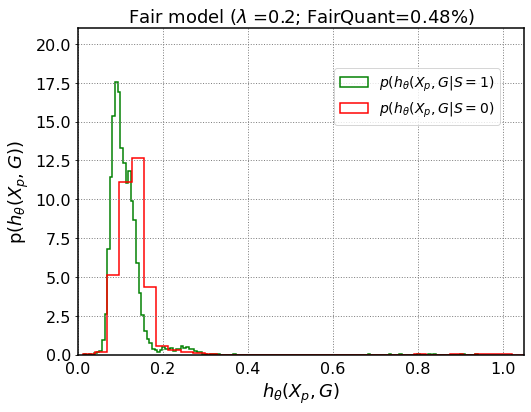

<Figure size 576x432 with 0 Axes>

In [123]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=150, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=150, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,21)
plt.xlim(0,1.05)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.84602416


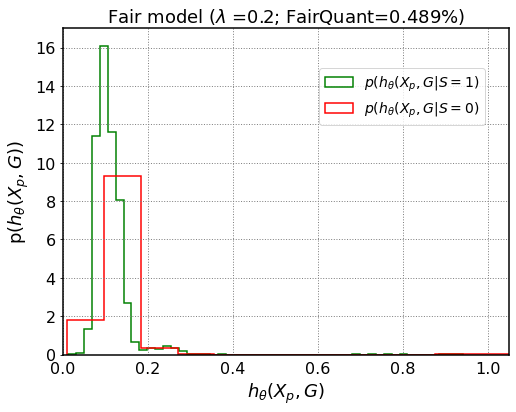

<Figure size 576x432 with 0 Axes>

In [124]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==0)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,17)
plt.xlim(0,1.05)

#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP0_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.84602416


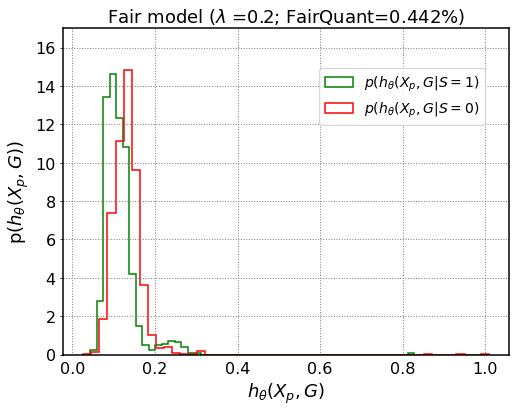

<Figure size 576x432 with 0 Axes>

In [125]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==1)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,17)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP1_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.84602416


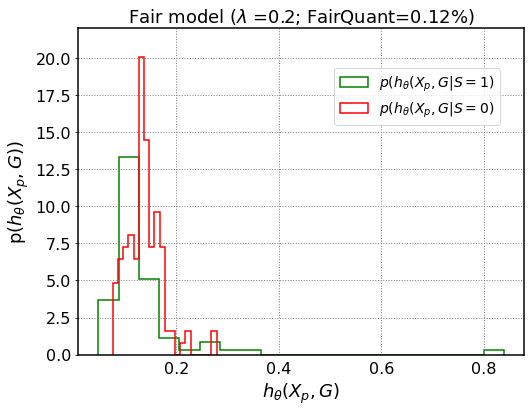

<Figure size 576x432 with 0 Axes>

In [126]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)>=2)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=20, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=20, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,22)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP2_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

In [111]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
g_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
g_pred2t= P1_NN.predict_g(G_test).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTrain2=HGR_NNP(torch.FloatTensor(g_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTest2=HGR_NNP(torch.FloatTensor(g_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" G HGR S2 train : ", G_HGRNNTrain2)
print(" G HGR S2 test : ",  G_HGRNNTest2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0],
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0],
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ]])
np.savetxt('table.out', table) 

 GINI Train :  0.32766944229283845
 GINI Test :  0.32975697079820165
 EDR Train :  0.08835582450161972
 EDR Test :  -0.12279924423220279
 MSE Train :  0.12941552633531944
 MSE Test :  0.13423799231587527
 DispER train :  62.84232262973399
 DispER test :  67.84531281935448
 FairQuant train :  (0.0003931894898414612, 2.576632915363142e-07)
 FairQuant test :  (0.0004587247967720032, 3.507140652891927e-07)
 RDC S1 train :  0.07373399213097653
 RDC S1 test :  0.07241482362788057
 RDC S2 train :  0.05994389604469667
 RDC S2 test :  0.07525679585497563
 HGR S1 train :  0.085389465
 HGR S1 test :  0.08513364
 HGR S2 train :  0.0
 HGR S2 test :  0.0
 G HGR S2 train :  0.007984397
 G HGR S2 test :  0.005902006


In [ ]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [109]:
table

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0.32766944229283845, 0.32975697079820165, 0.08835582450161972,
        -0.12279924423220279, 0.12941552633531944, 0.13423799231587527,
        (0.0003931894898414612, 2.576632915363142e-07),
        (0.0004587247967720032, 3.507140652891927e-07),
        0.0737482527641285, 0.07245224579319033, 0.05995347620919218,
        0.0752604165250205, array(0.00826486, dtype=float32),
        array(0.00600263, dtype=float32),
        array(0.08493204, dtype=float32),
        array(0.08092179, dtype=float32), array(0., dtype=float32)]],
      dtype=object)

In [105]:
len([lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train),
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ])


18

In [106]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 G HGR S2 train :  0.0079840105
 G HGR S2 test :  0.0079840105
